Importiamo tutte le librerie necessarie

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn import tree, neighbors
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from scipy import stats
from sklearn import svm
import matplotlib
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline





Leggo il mio file csv

In [2]:
df = pd.read_csv("./METABRIC_RNA_Mutation.csv")
df1 = df

print(df.head())
print(df.describe())
print(df.info())

/var/folders/t7/7795c57s1gg7w0jm6btz_vb00000gn/T/ipykernel_36396/3157117419.py:1: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./METABRIC_RNA_Mutation.csv")


   patient_id  age_at_diagnosis type_of_breast_surgery    cancer_type  \
0           0             75.65             MASTECTOMY  Breast Cancer   
1           2             43.19      BREAST CONSERVING  Breast Cancer   
2           5             48.87             MASTECTOMY  Breast Cancer   
3           6             47.68             MASTECTOMY  Breast Cancer   
4           8             76.97             MASTECTOMY  Breast Cancer   

                        cancer_type_detailed cellularity  chemotherapy  \
0           Breast Invasive Ductal Carcinoma         NaN             0   
1           Breast Invasive Ductal Carcinoma        High             0   
2           Breast Invasive Ductal Carcinoma        High             1   
3  Breast Mixed Ductal and Lobular Carcinoma    Moderate             1   
4  Breast Mixed Ductal and Lobular Carcinoma        High             1   

  pam50_+_claudin-low_subtype  cohort er_status_measured_by_ihc  ... mtap_mut  \
0                 claudin-low     1

In [3]:
df1.shape[:]

(1904, 693)

Vediamo i dati mancanti per ogni colonna e la relativa percentuale

In [5]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ["Total_NaN", "Percent_NaN"])
missing_data.head(10) #Mancano solo dati clinici, invece genetici no.

Total_NaN  Percent_NaN
tumor_stage                           501     0.263130
3-gene_classifier_subtype             204     0.107143
primary_tumor_laterality              106     0.055672
neoplasm_histologic_grade              72     0.037815
cellularity                            54     0.028361
mutation_count                         45     0.023634
er_status_measured_by_ihc              30     0.015756
type_of_breast_surgery                 22     0.011555
tumor_size                             20     0.010504
cancer_type_detailed                   15     0.007878
oncotree_code                          15     0.007878
tumor_other_histologic_subtype         15     0.007878
death_from_cancer                       1     0.000525
ar                                      0     0.000000
bche                                    0     0.000000
akr1c3                                  0     0.000000
akt3                                    0     0.000000
akr1c4                                  0     0.000000
akr1c2                                  0     0.000000
cdk8                                    0     0.000000
cyp11a1                                 0     0.000000
cdkn2c                                  0     0.000000
cyb5a                                   0     0.000000
ackr3                                   0     0.000000
cyp11b2                                 0     0.000000
cyp17a1                                 0     0.000000
cyp19a1                                 0     0.000000
cyp21a2                                 0     0.000000
cyp3a43                                 0     0.000000
cyp3a5                                  0     0.000000
cyp3a7                                  0     0.000000
ddc                                     0     0.000000
akr1c1                                  0     0.000000
patient_id                              0     0.000000
zfp36l1                                 0     0.000000
taf4b                                   0     0.000000
smarcc1                                 0     0.000000
smarcc2                                 0     0.000000
smarcd1                                 0     0.000000
spaca1                                  0     0.000000
stab2                                   0     0.000000
stmn2                                   0     0.000000
syne1                                   0     0.000000
taf1                                    0     0.000000
tbl1xr1                                 0     0.000000
utrn                                    0     0.000000
tg                                      0     0.000000
thada                                   0     0.000000
thsd7a                                  0     0.000000
ttyh1                                   0     0.000000

Text(0.5, 1.0, 'Missing value')

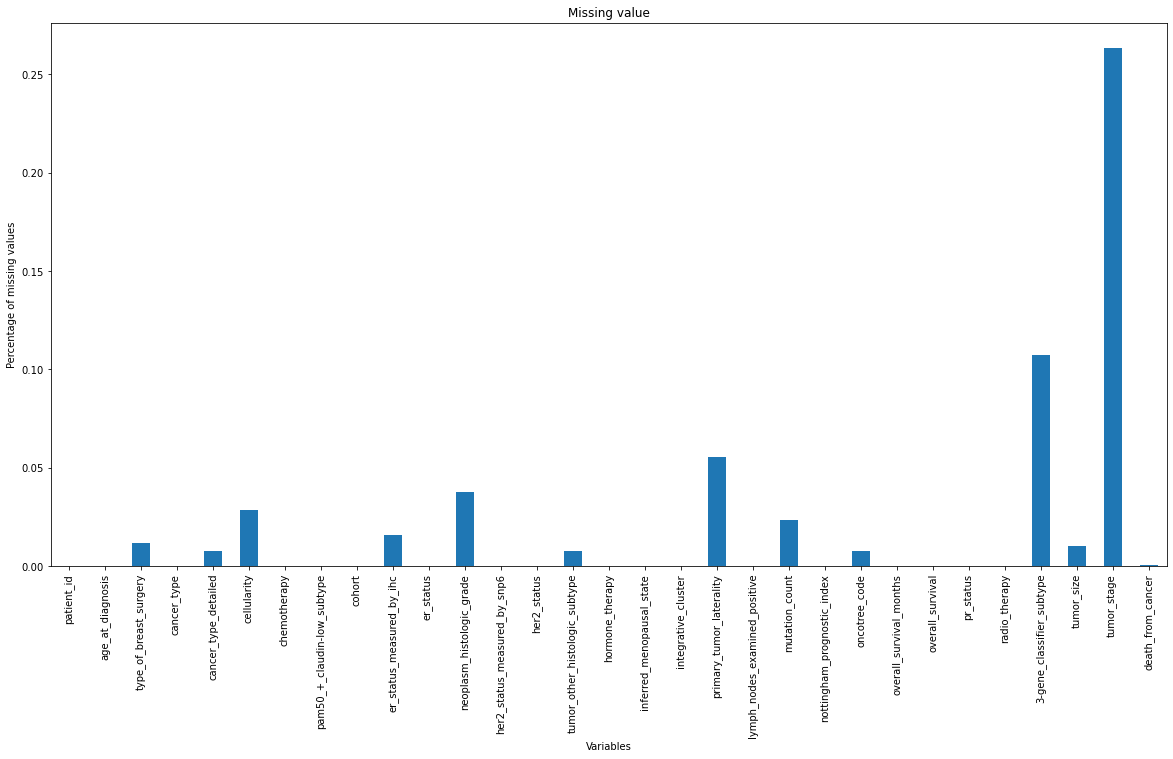

In [6]:
df1 = df.loc[:,'patient_id': 'death_from_cancer']
df1.isnull().mean().plot.bar(figsize=(20,10))
plt.ylabel('Percentage of missing values')
plt.xlabel('Variables')
plt.title('Missing value')

Come si può vedere, i dati clinici hanno alcune categorie in cui sono presenti dei dati mancanti, come per esempio il campo "tumor_stage" con il 26% di valori mancanti.

In [9]:
#Soffermiamoci solo su i dati delle persone che sono morte per la malattia o sono ancora vive, trascurando quelle che sono morte per altre cause
df = df[df['death_from_cancer'] != 'Died of Other Causes']
df = df.dropna()
#df.drop('death_from_cancer', axis = 1)
df.shape[:]


(854, 693)

A) Relazione tra dati clinici e risultati.

Estraggo dal dataset solo i dati relativi ai dati clinici

In [11]:
clinical_features_to_drop = df.columns[31:] #mi segno tutte le colonne da eliminare
clinical_df = df.drop(clinical_features_to_drop, axis = 1)
#Con axis =1 indico che devo eliminare delle colonne
#con .drop ottengo un nuovo dataframe (senza modificare quello originale) con tutte le colonne
#(perchè ho usato axis=1 per indicare le colonne) di prima tranne quelle passate come parametro
#se avessi usato axis=0 o default immagino, avrei eliminato delle righe e non delle colonne.
clinical_df.head()

patient_id  age_at_diagnosis type_of_breast_surgery    cancer_type  \
1            2             43.19      BREAST CONSERVING  Breast Cancer   
4            8             76.97             MASTECTOMY  Breast Cancer   
5           10             78.77             MASTECTOMY  Breast Cancer   
9           35             84.22             MASTECTOMY  Breast Cancer   
10          36             85.49             MASTECTOMY  Breast Cancer   

                         cancer_type_detailed cellularity  chemotherapy  \
1            Breast Invasive Ductal Carcinoma        High             0   
4   Breast Mixed Ductal and Lobular Carcinoma        High             1   
5            Breast Invasive Ductal Carcinoma    Moderate             0   
9           Breast Invasive Lobular Carcinoma        High             0   
10           Breast Invasive Ductal Carcinoma    Moderate             0   

   pam50_+_claudin-low_subtype  cohort er_status_measured_by_ihc  ...  \
1                         LumA     1.0                   Positve  ...   
4                         LumB     1.0                   Positve  ...   
5                         LumB     1.0                   Positve  ...   
9                         Her2     1.0                  Negative  ...   
10                        LumA     1.0                   Positve  ...   

   nottingham_prognostic_index  oncotree_code overall_survival_months  \
1                        4.020            IDC               84.633333   
4                        6.080           MDLC               41.366667   
5                        4.062            IDC                7.800000   
9                        3.056            ILC               36.266667   
10                       3.044            IDC              132.033333   

   overall_survival pr_status  radio_therapy 3-gene_classifier_subtype  \
1                 1  Positive              1     ER+/HER2- High Prolif   
4                 0  Positive              1     ER+/HER2- High Prolif   
5                 0  Positive              1     ER+/HER2- High Prolif   
9                 0  Negative              0     ER+/HER2- High Prolif   
10                0  Positive              1      ER+/HER2- Low Prolif   

   tumor_size tumor_stage  death_from_cancer  
1        10.0         1.0             Living  
4        40.0         2.0    Died of Disease  
5        31.0         4.0    Died of Disease  
9        28.0         2.0    Died of Disease  
10       22.0         4.0    Died of Disease  

[5 rows x 31 columns]

Creo una funzione per normalizzare tutti i valori numerici presenti nel dataset clinical_df


In [12]:
def to_standard (df):
    df_numeric = df[df.select_dtypes(include = np.number).columns.to_list()] #creo un nuovo dataframe che contiene solo le colonne numeriche che vado a normalizzare con StandardScaler
    #per ogni feature i-esima calcolo la media e la deviazione standard  e faccio x' = (x -mean i)/stddev i
    ss = StandardScaler()
    std = ss.fit_transform(df_numeric) #viene applicata la trasformazione di standardizzazione ai dati nel DataFrame num_df,
                                   #ottenendo come risultato una matrice numpy contenente i dati standardizzati.
                                   # Questa matrice non ha più l'informazione sugli indici e le colonne del DataFrame originale num_df.
    std_df = pd.DataFrame(std, index = df_numeric.index, columns = df_numeric.columns)
    return std_df

Ora vediamo dei grafici che connettono alcune colonne all'output finale.

Vedere anche progetto https://www.kaggle.com/code/julioam/breast-cancer-survival-analysis

<AxesSubplot:title={'center':'The Distribution of Numerical Attributes after standardization'}, xlabel='value', ylabel='variable'>

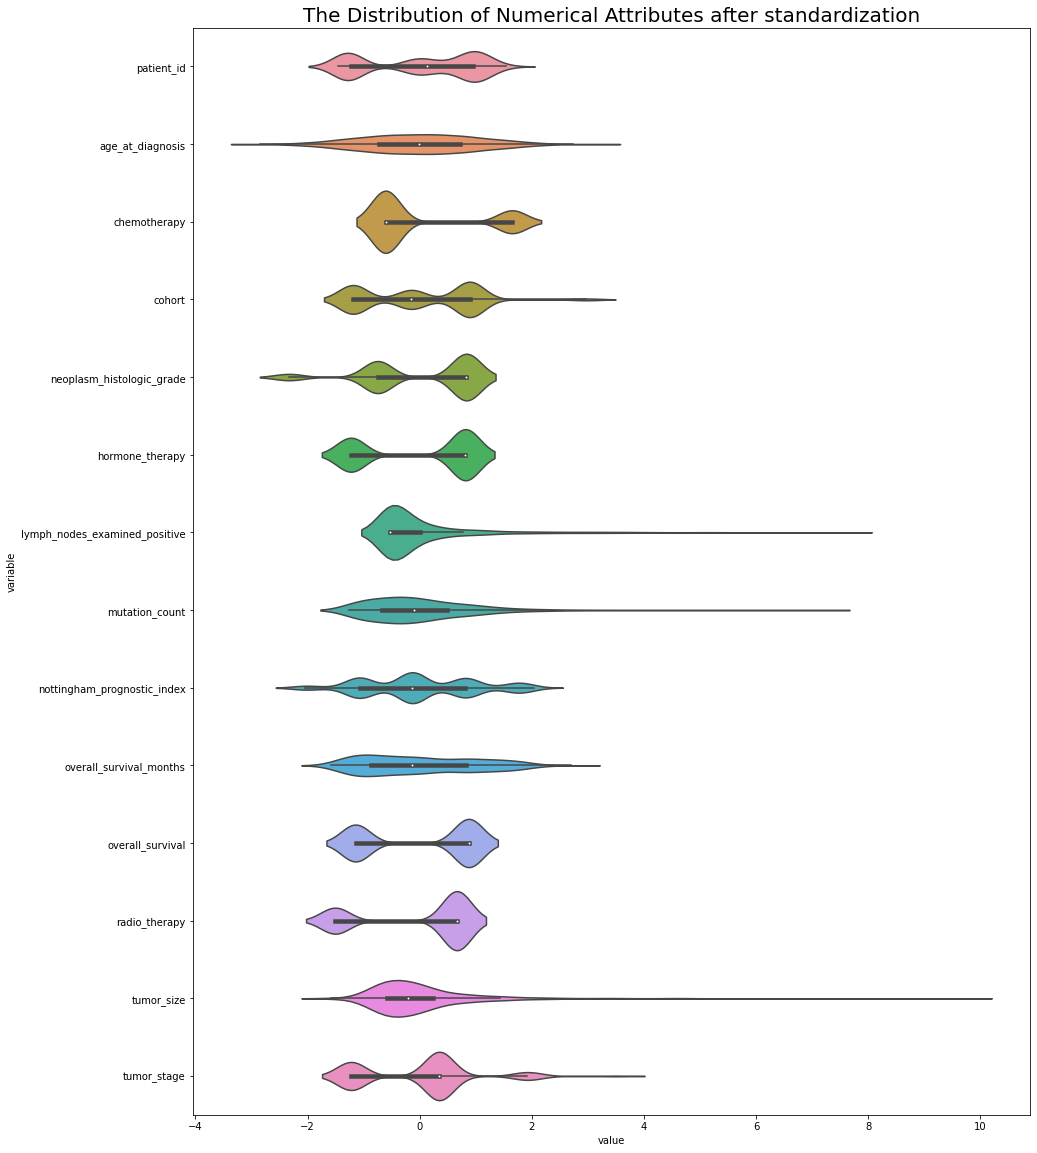

In [13]:
fig = plt.figure(figsize = (15,20))
plt.title('The Distribution of Numerical Attributes after standardization', fontsize = 20)

#sns.violinplot(data = to_standard(clinical_df), x = "value", y = "variable", hue="smoker")
sns.violinplot(y = "variable", x = "value", data = pd.melt(to_standard(clinical_df)))



/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

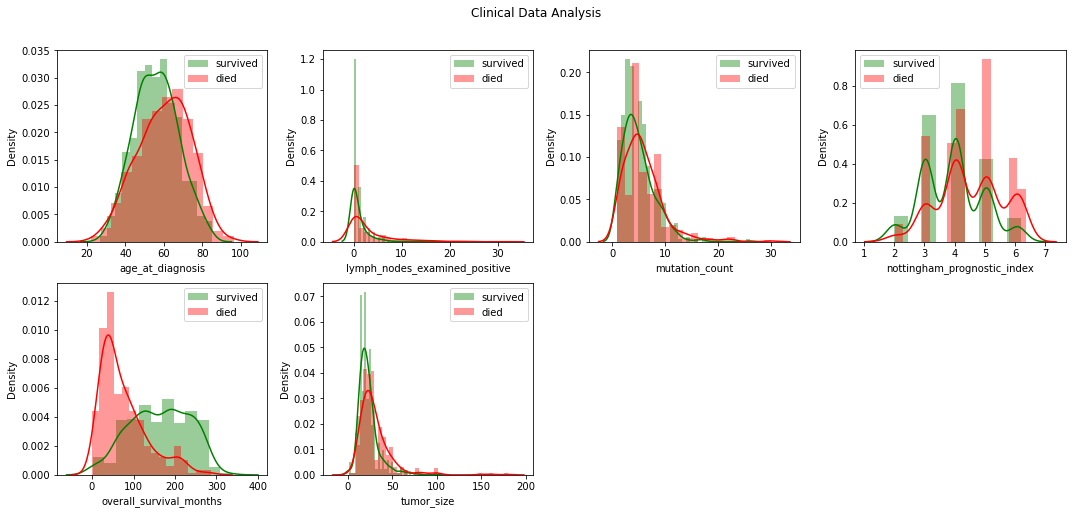

In [14]:
grafico = plt.figure(figsize = (15, 20))
#crea una nuova figura vuota utilizzando la libreria Matplotlib.
#L'argomento figsize specifica le dimensioni della figura in pollici (larghezza, altezza). Nell'esempio fornito, la figura viene impostata su una larghezza di 20 pollici e un'altezza di 15 pollici.
#Assegnando il risultato della chiamata plt.figure() alla variabile grafico, è possibile fare riferimento alla figura in seguito per aggiungere subplot o personalizzare la sua formattazione.
#Una volta creata la figura, è possibile aggiungere subplot, grafici o visualizzazioni utilizzando i metodi e le funzioni forniti da Matplotlib o altre librerie come Seaborn.

j = 0
num_clinical_columns = ['age_at_diagnosis', 'lymph_nodes_examined_positive','mutation_count','nottingham_prognostic_index', 'overall_survival_months', 'tumor_size' ]
for i in clinical_df[num_clinical_columns].columns:
    #In sintesi, clinical_df[num_clinical_columns] restituisce un DataFrame con le colonne specificate,
    # mentre clinical_df[num_clinical_columns].columns restituisce un oggetto Index contenente i nomi
    # delle colonne del DataFrame risultante. Potevo usare direttamente num_clinical_columns.
    plt.subplot(6, 4, j+1) #perchè la numerazione inizia da 1
    # Una griglia di subplot è un layout organizzato in una griglia di celle,
    # ognuna delle quali può contenere un grafico o una visualizzazione separata.
    # Ad esempio, una griglia di subplot può essere composta da 2 righe e 2 colonne,
    # formando una griglia di 4 celle. Ogni cella può essere considerata come un subplot
    # indipendente in cui è possibile disegnare un grafico separato. Nel nostro caso 6 righe e 4 colonne,
    # 6 x 4 = 24 subplot indipendenti. j (terzo parametro) indica la posizione all'interno della griglia. Con il
    # e aumentando j praticamente ogni nuovo grafico si troverà a fianco del precedente, nella nuova posizione.
    j += 1
    sns.distplot(clinical_df[i] [clinical_df['overall_survival']==1], color = 'g', label = 'survived')
    # crea un grafico a distribuzione della variabile clinical_df[i] per i casi in cui la colonna 'overall_survival'
    # del DataFrame clinical_df è uguale a 1 (indicando i casi di sopravvivenza).
    sns.distplot(clinical_df[i] [clinical_df['overall_survival']==0], color='r', label = 'died')
    plt.legend(loc = 'best')
    #Idem ma per i casi di decesso
    grafico.suptitle('Clinical Data Analysis')

grafico.tight_layout() # viene utilizzata per migliorare la disposizione dei subplot all'interno di una figura, in modo che siano distribuiti in modo uniforme e che non si sovrappongano.

grafico.subplots_adjust(top=0.95) #viene utilizzata per regolare i margini superiori della figura, consentendo di spostare verso il basso l'area di disegno dei subplot.

plt.show()
#Il collegamento tra fig o 'grafico'(nel mio caso) e i subplot avviene in modo implicito attraverso la sequenza di comandi che
#  utilizzano la libreria Matplotlib. Quando si crea un nuovo subplot con plt.subplot(),
# il subplot viene automaticamente aggiunto alla figura 'variabile' grafico in questo caso.
# Inoltre, tutte le operazioni di tracciamento dei grafici, come sns.distplot(),
# vengono eseguite all'interno del contesto della figura 'grafico'.
# In sostanza, la figura 'grafico' o fig rappresenta il contenitore principale dei subplot
# creati con plt.subplot(), anche se non viene fatto un collegamento esplicito
#  nel codice. Questo è il comportamento predefinito di Matplotlib quando si
# lavora con una singola figura.


Età alla diagnosi

I pazienti sopravvissuti hanno una distribuzione bimodale
I pazienti deceduti hanno lasciato una distribuzione distorta
Linfonodi esaminati positivi: sia i pazienti sopravvissuti che quelli deceduti presentano una distribuzione asimmetrica a destra

Conteggio delle mutazioni: sia i pazienti sopravvissuti che quelli morti hanno una distribuzione distorta a destra

Indice prognostico di Nottingham: sia i pazienti sopravvissuti che quelli deceduti hanno una distribuzione multimodale

Mesi di sopravvivenza globale

I pazienti sopravvissuti hanno una distribuzione bimodale
I pazienti deceduti hanno una distribuzione distorta a destra
Dimensioni del tumore: sia i pazienti sopravvissuti che quelli deceduti hanno una distribuzione distorta a destra

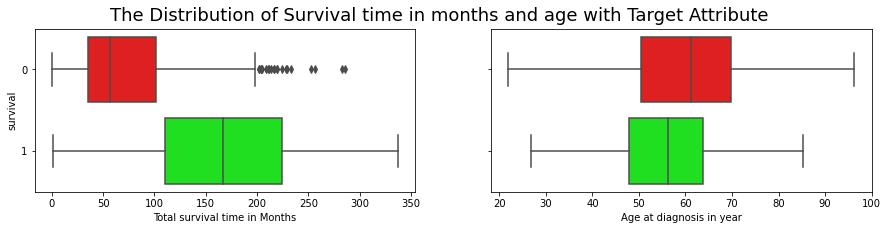

In [16]:
#La differenza principale tra "plt.subplots" e "plt.subplot" è che "plt.subplots" crea una griglia di subplot
# in una singola chiamata, restituendo sia la figura che gli assi dei subplot,
# mentre "plt.subplot" crea un singolo subplot in una chiamata, restituendo solo gli assi del subplot.
# Utilizzando "plt.subplots", è possibile accedere agli assi dei subplot individuandoli tramite l'indice nell'elenco "ax".
# Ad esempio, "ax[0]" rappresenta il primo subplot nella griglia e "ax[1]" rappresenta il secondo subplot.

fig, ax = plt.subplots(ncols = 2, figsize = (15,3), sharey = True)
#crea una figura con due assi, disposti in una griglia con due colonne (ncols=2) e una riga.
# La dimensione totale della figura è impostata su (15, 3) utilizzando il parametro figsize,
#che specifica la larghezza e l'altezza della figura in pollici.
# Inoltre, il parametro sharey=True viene utilizzato per condividere lo stesso asse y tra i due assi,
# il che significa che entrambi gli assi avranno la stessa scala sull'asse y.Il risultato di questo codice
# è una figura con due assi, pronti per essere utilizzati per disegnare grafici.
#Qui utilizzo il primo asse ovvero ax[0]
two_colors = ["#FF0000", "#00FF00"]
sns.boxplot(x = 'overall_survival_months', y = 'overall_survival', orient = 'h', data = clinical_df, ax = ax[0], palette = two_colors)
#Qui utilizzo il secondo asse ovvero ax[1]
sns.boxplot(x = 'age_at_diagnosis', y = 'overall_survival', orient = 'h', data = clinical_df, ax = ax[1], palette = two_colors)

fig.suptitle('The Distribution of Survival time in months and age with Target Attribute', fontsize = 18)

ax[0].set_xlabel('Total survival time in Months')
ax[0].set_ylabel('survival')
ax[1].set_xlabel('Age at diagnosis in year')
ax[1].set_ylabel('')

plt.show()
#Per confrontare le due classi di pazienti che sono sopravvissuti e i pazienti che non lo hanno fatto,
# possiamo vedere la differenza tra le due distribuzioni nella colonna 'age_at_diagnosis', in quanto i pazienti
# che erano più giovani al momento della diagnosi di cancro al seno avevano maggiori probabilità di sopravvivere.
#Qui possiamo notare come, chi muore per la malattia di solito muore relativamente subito e non dopo vari mesi.

#three_colors = ["#00FF00", "#FF0000", "#0000FF"]

In [17]:
#Posso confrontare ancora : Tumor_size e tumor stage
#Sopravvivenza o no in base all'età, diametro tumore, numero di linfonodi positivi e di questi quanti morti per tumore e quanti per altre cause o ancora vivi
#Confronto tra chi ha fatto la chemio, la terapia ormonale e chi radio terapia ed è vivo o morto (e chi ha fatto più cose insieme)
colonne = ['tumor_size', 'tumor_stage']
clinical_df[colonne]

tumor_size  tumor_stage
1           10.0          1.0
4           40.0          2.0
5           31.0          4.0
9           28.0          2.0
10          22.0          4.0
...          ...          ...
1613        16.0          1.0
1616        15.0          1.0
1619        20.0          1.0
1623        20.0          2.0
1664        22.0          2.0

[854 rows x 2 columns]

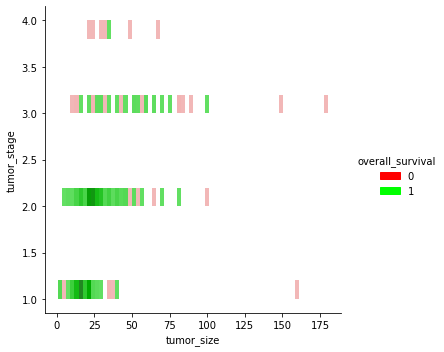

In [18]:
#La grandezza del tumore va in base allo stadio del tumore
grafico = sns.displot(x ='tumor_size', y ='tumor_stage',  data = clinical_df, hue='overall_survival', palette=two_colors)
#grafico.invert_yaxis()

Text(0, 0.5, 'Sopravvissuti')

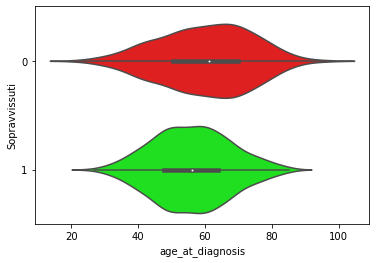

In [19]:
#Sopravvivenza o no in base all'età
sns.violinplot(x = 'age_at_diagnosis', y = 'overall_survival', data = clinical_df, palette = two_colors, orient = 'h')
plt.ylabel("Sopravvissuti")

Stage 0.0

Patients who died have same tumor size, around 60-70
Patients who survived have tumor size between 15-35
Stage 1.0 Patients who died and survived has relatively same tumor size distribution, except 1 died patients whose tumor size > 150

Stage 2.0 Patients who died and survived has a little bit difference in tumor size distribution and has almost the same median

Stage 3.0

Patients who died have variety of tumor size, from around 10 to more than 175
Patients who survived have tumor size between around 20 and 100
Stage 4.0

Patients who died have tumor size between 20-70
Patients who survived have same tumor size, around 60-70


<AxesSubplot:xlabel='tumor_size', ylabel='overall_survival'>

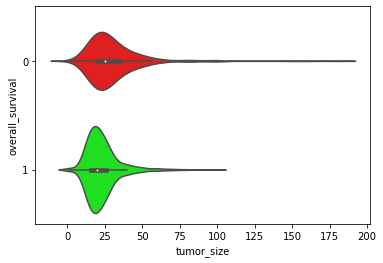

In [20]:
#Sopravvivenza o no in base al diametro del tumore
sns.violinplot(x = 'tumor_size', y = 'overall_survival', orient = 'h', data = clinical_df, palette = two_colors)

Faccio dei sottinsiemi che mi serviranno per i grafici


In [21]:
died = clinical_df[clinical_df['overall_survival']==0]
#clinical_df[clinical_df['overall_survival']==0]:
#Questa espressione viene utilizzata per filtrare il DataFrame clinical_df e
#restituire solo le righe in cui la colonna 'overall_survival' ha il valore 0.
# Quindi, l'output sarà un DataFrame contenente solo le righe che soddisfano
#la condizione.
#clinical_df['overall_survival']==0: Questa espressione viene utilizzata per creare
# una maschera booleana che indica se ciascun elemento della colonna
#'overall_survival' è uguale a 0 o no. L'output sarà una serie di valori booleani,
#con True corrispondente agli elementi che soddisfano la condizione e False
#corrispondente agli elementi che non la soddisfano.

survived = clinical_df[clinical_df['overall_survival']==1]

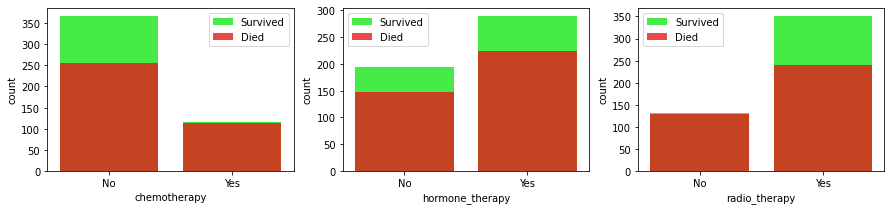

In [22]:
fig, ax = plt.subplots(ncols = 3, figsize= (15,3))
sns.countplot(x = survived['chemotherapy'], color = two_colors[1], label = 'Survived', ax = ax[0], saturation = 0.80, alpha = 0.8)
sns.countplot(x = died['chemotherapy'], color = two_colors[0], label = 'Died', ax = ax[0], saturation = 0.80, alpha = 0.8)
ax[0].set(xticklabels=['No','Yes'])
ax[0].legend()

sns.countplot(x = survived['hormone_therapy'], color = two_colors[1], label='Survived', ax=ax[1], saturation=0.80, alpha = 0.8)
sns.countplot(x = died['hormone_therapy'], color = two_colors[0], label='Died', ax=ax[1], saturation=0.80, alpha = 0.8)
ax[1].set(xticklabels=['No','Yes'])
ax[1].legend()

sns.countplot(x = survived['radio_therapy'], color = two_colors[1], label='Survived', ax=ax[2], saturation=0.80, alpha = 0.8)
sns.countplot(x = died['radio_therapy'], color = two_colors[0], label='Died', ax=ax[2], saturation=0.80, alpha = 0.8)
ax[2].set(xticklabels=['No','Yes'])
ax[2].legend()

plt.show()


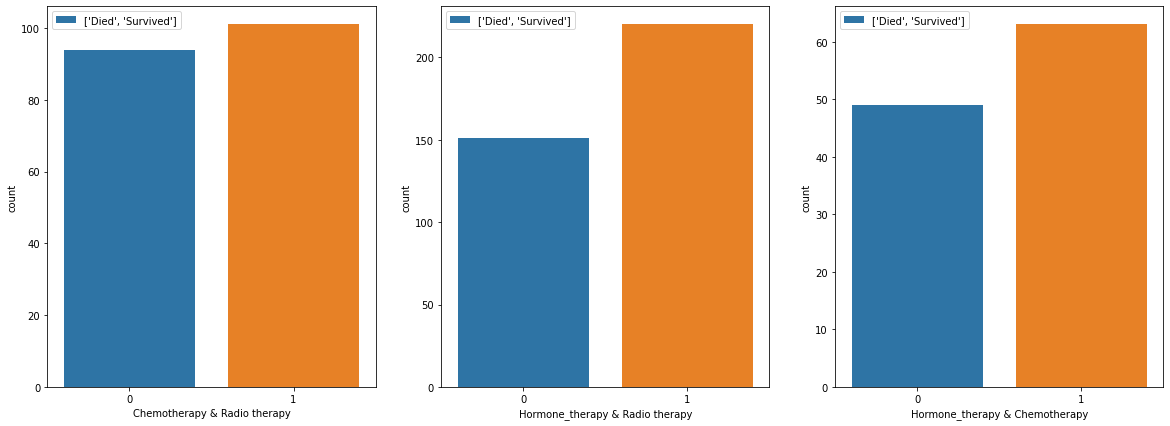

In [23]:
#Di chi ha fatto sia chemio che radio
fig, ax = plt.subplots(ncols = 3, figsize = (20,7))
morti_con_2 = clinical_df[(clinical_df['chemotherapy'] == True) & (clinical_df['radio_therapy']== True)]
sns.countplot(x = morti_con_2['overall_survival'], label = ['Died', 'Survived'], saturation = 0.80, ax = ax[0])
ax[0].legend()
ax[0].set_xlabel('Chemotherapy & Radio therapy')

morti_con_2 = clinical_df[(clinical_df['hormone_therapy'] == True) & (clinical_df['radio_therapy']== True)]
sns.countplot(x = morti_con_2['overall_survival'], label = ['Died', 'Survived'], saturation = 0.80, ax = ax[1])
ax[1].legend()
ax[1].set_xlabel('Hormone_therapy & Radio therapy')

morti_con_2 = clinical_df[(clinical_df['hormone_therapy'] == True) & (clinical_df['chemotherapy']== True)]
sns.countplot(x = morti_con_2['overall_survival'], label = ['Died', 'Survived'], saturation = 0.80, ax = ax[2])
ax[2].legend()
ax[2].set_xlabel('Hormone_therapy & Chemotherapy')

plt.show()




Chemotherapy treatment

The difference between died class and survived class is large for patient with chemotherapy compared to patients without chemotherapy
Patients in died class without chemotherapy is very high, more than 800. Meanwhile, patients in died class with chemotherapy is not so high, a little over 200
Hormonal therapy

The difference between died class and survived class is quite large for patient with hormonal therapy compared to patients without hormonal therapy
Patients in died class with chemotherapy is quite high, a little bit under 700. Patients in died class with chemotherapy is not so high, a little over 400
Radio therapy

The difference between died class and survived class is quite large for patient with radio therapy compared to patients without radio therapy
Number of patients in died class both with radio therapy and without radio therapy is the highest compared to other therapy method

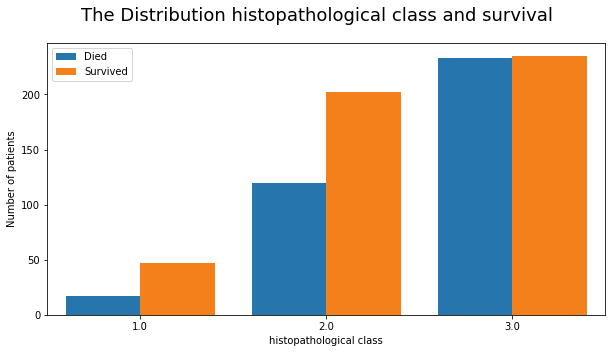

In [24]:
fig, ax = plt.subplots( figsize=(10,5))
fig.suptitle('The Distribution histopathological class and survival', fontsize = 18)

sns.countplot(x='neoplasm_histologic_grade', hue='overall_survival' ,data = clinical_df, ax=ax, saturation=0.90)
ax.legend([ 'Died', 'Survived'])

ax.set_xlabel('histopathological class')
ax.set_ylabel('Number of patients')

plt.show()

The patient in died class is always higher than in survived class except for class 1.0
The difference of number of patients both died and survived class for class 1.0 is high compared to other class

CORRELAZIONE TRA ATTRIBUTI CLINICI

Nel gruppo di denominazione del tipo di cancro, "tumor_other_histologic_subtype", "oncotree_code", "cancer_type" e "cancer_type_detailed" presentano diversi nomi di tipo di cancro. Queste variabili presentano informazioni ridondanti e una potrebbe essere utilizzata nel modello. Diverse variabili ridondanti potrebbero anche essere trovate nel gruppo di informazioni sul tumore. Le variabili "er_status" e "her2_status" presentano le stesse informazioni rispetivamente con "erstatusmeasuredbyihc" e "her2statusmeasuredbysnp6". Inoltre, "X3.gene_classifier_subtype" presenta "her2_status" e "er_status" in un altro modo e non contiene nuove informazioni.

Make overall_survival dataset by removing overall_survival_months and death_from_cancer, which are too similar to overall_survival to be useful.

Rimuovi cancer_type poiché è tutto cancro al seno.



La funzione pd.get_dummies() del modulo pandas viene utilizzata per eseguire la codifica one-hot delle variabili categoriche presenti in un DataFrame.

La codifica one-hot trasforma le variabili categoriche in una rappresentazione numerica binaria. Crea nuove colonne nel DataFrame, corrispondenti alle categorie uniche della variabile categorica, e assegna un valore di 1 nella colonna corrispondente alla categoria effettiva, mentre assegna un valore di 0 nelle altre colonne.
Esempio: abbiamo un DataFrame con una colonna chiamata "Colore" contenente categorie come "Rosso", "Blu" e "Verde". Utilizzando pd.get_dummies(),
-> pd.get_dummies(df, columns=['Colore'])
abbiamo applicato la codifica one-hot alla colonna "Colore". Ciò ha generato tre nuove colonne nel DataFrame risultante: "Colore_Rosso", "Colore_Blu" e "Colore_Verde". Ogni riga del DataFrame ha un valore di 1 nella colonna corrispondente alla categoria effettiva e 0 nelle altre colonne.

La funzione pd.get_dummies() offre anche opzioni per specificare il prefisso delle nuove colonne, gestire valori mancanti, escludere una categoria di riferimento e altro ancora. Queste opzioni possono essere passate come argomenti aggiuntivi alla funzione per personalizzare il comportamento della codifica one-hot.

La codifica one-hot è spesso utilizzata come preparazione dei dati per algoritmi di machine learning che richiedono input numerici. Consente di rappresentare in modo adeguato le variabili categoriche nel processo di addestramento dei modelli senza assegnare una relazione ordinale ai valori delle categorie.

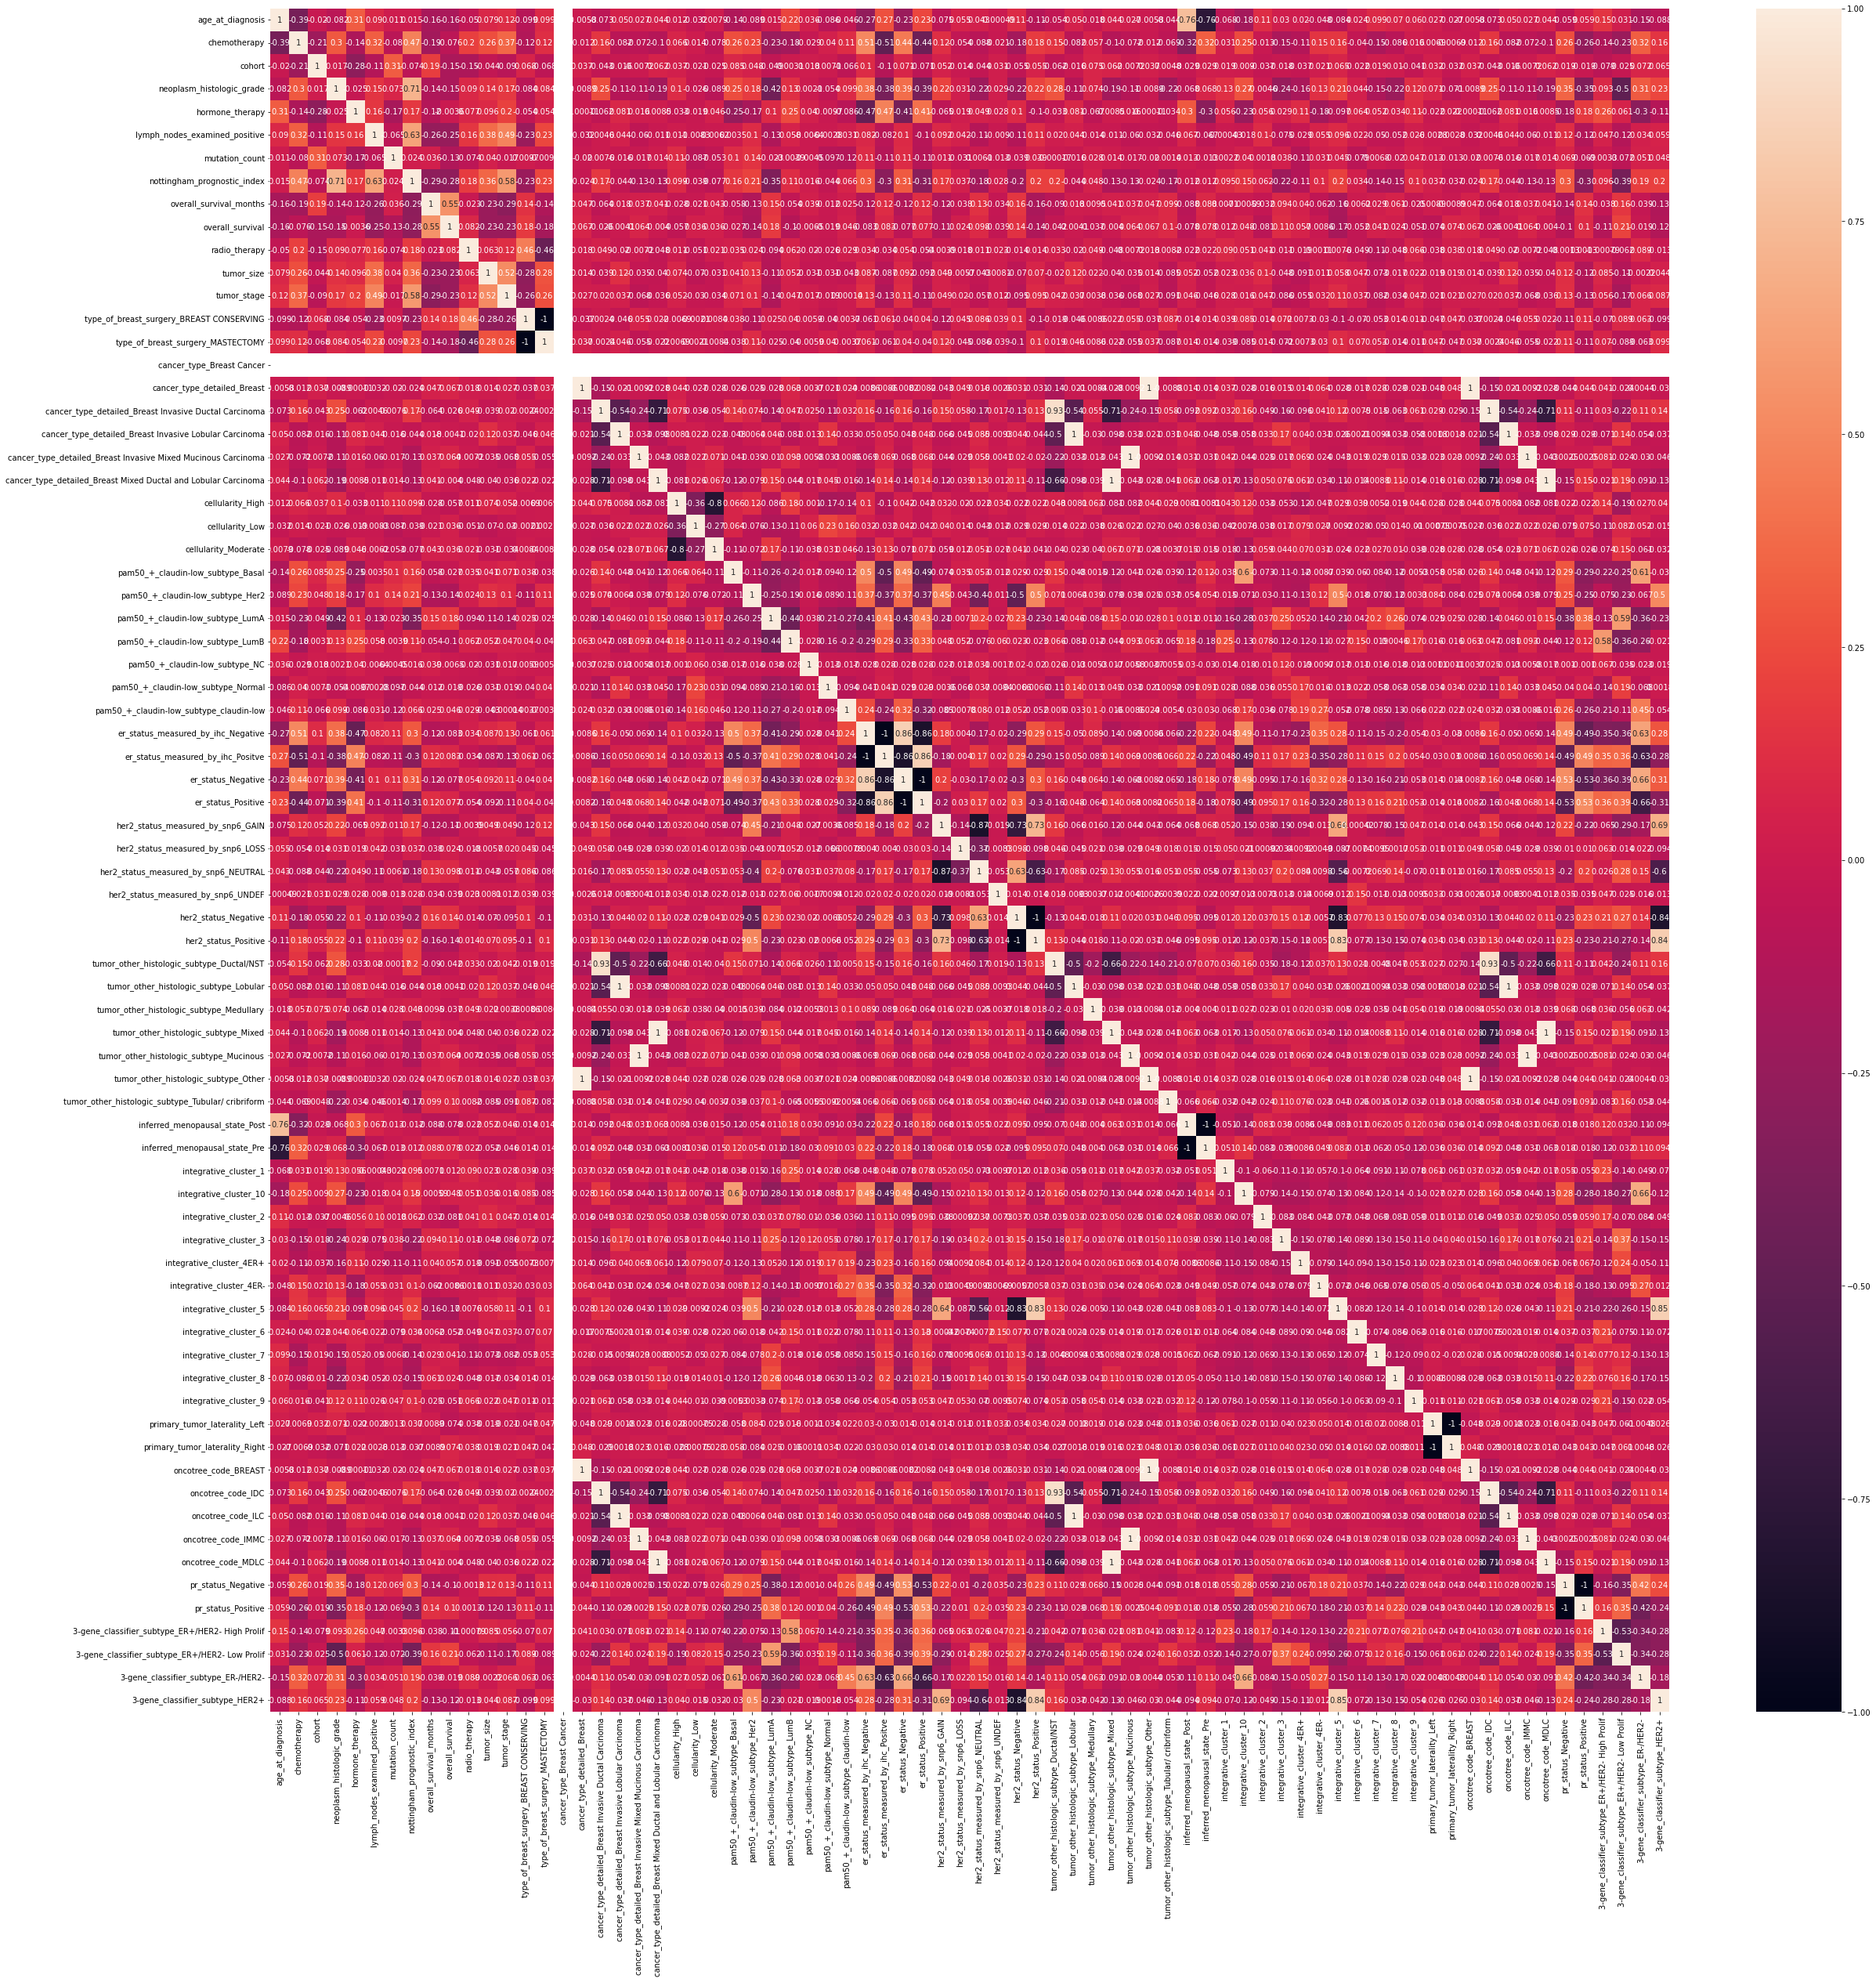

In [25]:
#Inizio eliminando patient_id che non mi serve
plt.figure(figsize = (40,40))
data = clinical_df.drop('patient_id', axis = 1)
data = data.drop('death_from_cancer', axis = 1)

#Inizio considerando le colonne non numeriche e quindi categoriche
nomi_colonne_da_trasformare = data.select_dtypes(include = ['object']).columns.to_list()
data_for_matrix = pd.get_dummies(data = data, columns=nomi_colonne_da_trasformare)
sns.heatmap(data = data_for_matrix.corr(), annot=True)
plt.show()


In [26]:
corr1 = data_for_matrix.corr()
correlazione = np.argsort(-corr1.corr().values, axis=1)
corrValue = corr1.apply(lambda row: row.nlargest(2).values[-1],axis=1)
dfClinicalData = pd.DataFrame({'Correlated Clinical_data': corr1.columns[correlazione[1]], 'Pearson Correlation': corrValue}, index=corr1.index)
print(dfClinicalData.head(5))

                                     Correlated Clinical_data  \
age_at_diagnosis                                 chemotherapy   
chemotherapy               er_status_measured_by_ihc_Negative   
cohort                                     er_status_Negative   
neoplasm_histologic_grade         nottingham_prognostic_index   
hormone_therapy                     neoplasm_histologic_grade   

                           Pearson Correlation  
age_at_diagnosis                      0.759608  
chemotherapy                          0.506572  
cohort                                0.313549  
neoplasm_histologic_grade             0.710007  
hormone_therapy                       0.472373  


In [27]:
#Abbiamo varie correlazioni. Per esempio:

data_for_matrix.corr()['overall_survival'].sort_values(ascending = False)
#data_for_matrix.corr()['death_from_cancer_Died of Disease'].sort_values(ascending = False)


overall_survival                                  1.000000
overall_survival_months                           0.551656
3-gene_classifier_subtype_ER+/HER2- Low Prolif    0.214730
type_of_breast_surgery_BREAST CONSERVING          0.178420
pam50_+_claudin-low_subtype_LumA                  0.176005
                                                    ...   
tumor_stage                                      -0.227735
tumor_size                                       -0.232410
lymph_nodes_examined_positive                    -0.247064
nottingham_prognostic_index                      -0.277347
cancer_type_Breast Cancer                              NaN
Name: overall_survival, Length: 74, dtype: float64

In [28]:
overvall_survival_correlation = pd.DataFrame(data = data_for_matrix.corr()['overall_survival'].sort_values(ascending = False) )
overvall_survival_correlation

overall_survival
overall_survival                                        1.000000
overall_survival_months                                 0.551656
3-gene_classifier_subtype_ER+/HER2- Low Prolif          0.214730
type_of_breast_surgery_BREAST CONSERVING                0.178420
pam50_+_claudin-low_subtype_LumA                        0.176005
...                                                          ...
tumor_stage                                            -0.227735
tumor_size                                             -0.232410
lymph_nodes_examined_positive                          -0.247064
nottingham_prognostic_index                            -0.277347
cancer_type_Breast Cancer                                    NaN

[74 rows x 1 columns]

In [29]:
#statistics for the no treatment group and comparison with the baseline
no_treatment = clinical_df[(clinical_df['chemotherapy']==0) & (clinical_df['hormone_therapy']==0) & (clinical_df['radio_therapy']==0)]
print("Number of patients who had no treatment: " , no_treatment.shape[0])
print("Proportion of survival with no treatment: " , ("%.3f" %np.mean(no_treatment["overall_survival"])))
print("Baseline proportion of survival in all groups: ", ("%.3f" %np.mean(df["overall_survival"])))

#The proportion of survival with no treatment is quite close to the baseline proportion of survival in all group

Number of patients who had no treatment:  100
Proportion of survival with no treatment:  0.550
Baseline proportion of survival in all groups:  0.567


In [30]:
#What the average patient looks like
print("Mean of age : " + "%.3f" %np.mean(clinical_df['age_at_diagnosis']))
print("Most occurring tumour stage :", int(stats.mode(clinical_df['tumor_stage'])[0]))
print("Most occurring histopathological type :", int(stats.mode(clinical_df['neoplasm_histologic_grade'])[0]))
print("Mean of tumour diameter : " + "%.3f" %np.mean(clinical_df['tumor_size']))
print("Probability of survival : "+ "%.3f" %(clinical_df["overall_survival"].value_counts()/clinical_df["overall_survival"].count()).iloc[1])

Mean of age : 57.800
Most occurring tumour stage : 2
Most occurring histopathological type : 3
Mean of tumour diameter : 26.244
Probability of survival : 0.433


A) Classification with only clinical attributes¶


In [34]:
#L'argomento dummy_na=True nel metodo pd.get_dummies() indica se includere una colonna addizionale
# per rappresentare i valori mancanti (NaN) nelle variabili categoriche durante la codifica one-hot.

data = clinical_df.drop('death_from_cancer', axis = 1)
columns_object = data.select_dtypes(include = ['object']).columns.to_list()
dataset = pd.get_dummies(data.drop('patient_id',axis=1 ), columns = columns_object, dummy_na = False)
dataset.dropna(inplace = True)
dataset.shape[:]

#dataset = to_standard(dataset)

X = dataset.drop(['overall_survival'], axis = 1)
y = dataset['overall_survival']

#Il parametro stratify nel metodo train_test_split viene utilizzato per
#garantire che la distribuzione delle classi target sia mantenuta nelle
#suddivisioni tra dati di addestramento e dati di test.
#Quando si imposta stratify=y, il metodo train_test_split assicura che
#la proporzione delle classi target all'interno di y sia preservata sia nel
# set di addestramento che nel set di test. In altre parole, se ci sono
#classi sbilanciate nel tuo dataset, l'impostazione di stratify=y assicurerà
# che i dati di addestramento e di test abbiano una distribuzione simile delle classi.

X_train, X_test, y_train, y_test = train_test_split(to_standard(X),y, stratify = y)



Definiamo una funzione comune che verrà richiamata per effettuare il predict e i relativi test

The following metrics were used to evaluate the outputs of the model:

1) The Confusion Matrix, which includes the four possible outcomes of binary classification:

• True Positive (TP): The number of patients who survived and were classified as survived.

• True Negative (TN): The number of patients who died and were classified as died.

• False Negative (FN): The number of patients who survived and were classified as died.

• False Positive (FP): The number of patients who died and were classified as died.

2) The AUC is the Area Under the Receiver Operating Characteristic (ROC) Curve. It can be interpreted as the extent of how well the model is able to distinguish between the two different classes.

3) Accuracy: Number of correct assessments (True positives + true negatives) / Total number of instances

4) Precision
5) Recall

In [39]:
def metrics(model, X_train, X_test, y_train, y_test, kfold):

  ''' Dopo aver eseguito la cross-validation e ottenuto i punteggi di valutazione per ciascun fold, 
  hai un'idea migliore delle prestazioni medie del tuo modello su dati simili ma non identici. 
  Tuttavia, questa è ancora una valutazione su dati di addestramento.
  Per ottenere una valutazione finale delle prestazioni del modello, è necessario addestrare il modello completo 
  sui dati di addestramento originali (senza suddivisione in fold) e quindi usarlo per fare previsioni sui dati di test, 
  che sono completamente separati dai dati di addestramento. Questo ti darà una valutazione delle prestazioni del modello
  sui dati "non visti" e rappresenta la valutazione finale del tuo modello.''' 

  model.fit(X_train, y_train)

  results = cross_val_score(model, X_train, y_train, cv = kfold)

#La funzione cross_val_score di scikit-learn viene utilizzata per eseguire
#la validazione incrociata (cross-validation) di un modello di machine learning.
#Fare cross-validazione significa dividere i nostri dati di addestramento in diverse porzioni 
# #e testare il nostro modello su parti alcune di queste parti. Il test set continua ad essere usato 
# #per la valutazione finale, mentre le performance del modello vengono valutate sulle porzioni generate dalla cross-validazione.
#La validazione incrociata è una tecnica statistica che viene utilizzata
#per valutare le prestazioni di un modello su un set di dati limitato.
#Invece di suddividere il set di dati in un unico set di addestramento, 
# la validazione incrociata suddivide il set di dati di addestramento
#in diverse parti chiamate "fold" e addestra e valuta il modello su diverse
#combinazioni di queste parti.
#La funzione cross_val_score semplifica l'esecuzione della validazione incrociata.
# Prende in input un modello, un set di dati di input (X) e un vettore di
#etichette di output (y), e restituisce una lista di punteggi di valutazione
#ottenuti per ogni fold. Ad esempio, se si specifica cv=5, cross_val_score
#dividerà il set di dati in 5 fold, addestrerà il modello su 4 fold e valuterà
#le prestazioni sul fold rimanente. Ripeterà questa procedura per tutte
#le combinazioni di fold e restituirà una lista di punteggi di
#valutazione ottenuti. In sintesi, cross_val_score viene utilizzata per
#ottenere una stima affidabile delle prestazioni del modello
#tramite la validazione incrociata, aiutando a valutare l'accuratezza e
#la stabilità del modello su diverse partizioni dei dati di addestramento e test.

#Utilizzando sia predict che cross_val_score,
#puoi ottenere una valutazione dettagliata delle prestazioni del
#modello sia su un set di dati specifico che tramite la validazione incrociata.

  y_pred = model.predict(X_test)
#Questo metodo utilizza il modello con la migliore combinazione
#di iperparametri trovata durante la ricerca della griglia per fare
#previsioni sul set di dati di input X.
#La migliore combinazione di iperparametri è determinata
#utilizzando GridSearchCV, che esamina diverse combinazioni di
#iperparametri e restituisce il modello che ha ottenuto il
#punteggio migliore durante la ricerca. Quindi, logistic_regression.predict(X)
#utilizza il modello con i migliori iperparametri trovati durante la
#ricerca della griglia per fare previsioni.

  print("CV scores: ", results);
  print("CV Standard Deviation: ", results.std());

#Quando si utilizza model.score(X_train, y_train),
#si passa il set di dati di addestramento X_train e le
#etichette di classe corrispondenti y_train al modello.
#La funzione calcola quindi il punteggio del modello sui dati
#di addestramento, che solitamente rappresenta l'accuratezza delle
#previsioni del modello sui dati utilizzati per addestrarlo.
#E' la stessa cosa di fare predict su X_train o X_test e poi calcolare
#l'accuracy con y_test o y_pred

  test_score = model.score(X_test, y_test)

  print('CV Mean score: ', results.mean());
  print();
  print('Train score: ', model.score(X_train, y_train))
  print('Test score/Accuratezza del modello: ', test_score)
  print()

# Calcola la precisione
  precision = precision_score(y_test, y_pred)
  print("Precision:", precision)

# Calcola il recall
  recall = recall_score(y_test, y_pred)
  print("Recall:", recall)

#Calcola la matrice di confusione
  matrix = confusion_matrix(y_test, y_pred)
  print("Matrice di confusione :") #1 riga 1 colonna veri negativi (0), 1 riga 2 colonna Falsi Positivi
                                   #2 riga 1 colonnna falsi negativi, 2 riga 2 colonna Veri Positivi
  print(matrix)
  print()
  return y_pred, test_score, results.mean()






GridSearchCV è una classe in scikit-learn che viene utilizzata per eseguire una ricerca esaustiva dei parametri ottimali per un modello di machine learning. Questa classe implementa un approccio di ricerca della griglia, che consiste nel valutare le prestazioni del modello su diverse combinazioni di iperparametri specificati dall'utente.

Durante la ricerca della griglia, vengono forniti un modello di base e un dizionario di iperparametri da testare. GridSearchCV esegue una validazione incrociata (cross-validation) del modello su tutte le possibili combinazioni di iperparametri e restituisce i risultati.

L'obiettivo di GridSearchCV è di trovare la combinazione di iperparametri che massimizza le prestazioni del modello, misurate tramite una specifica metrica di valutazione. Di solito, si esegue la ricerca della griglia su un set di addestramento e si valuta il modello ottimale su un set di test separato.

Una volta completata la ricerca della griglia, è possibile accedere ai risultati attraverso gli attributi dell'oggetto GridSearchCV, ad esempio i migliori parametri (best_params_) e il miglior punteggio (best_score_).

L'utilizzo di GridSearchCV semplifica il processo di selezione dei migliori iperparametri per un modello e aiuta a trovare una configurazione ottimale che massimizza le prestazioni del modello.

L1 e L2 penalty sono due tecniche di regolarizzazione utilizzate nei modelli di machine learning, inclusa la regressione logistica, per evitare il sovra-adattamento (overfitting) e migliorare la capacità di generalizzazione del modello.

L1 Penalty (Regolarizzazione L1):
La regolarizzazione L1 aggiunge un termine di penalità proporzionale alla somma degli valori assoluti dei coefficienti del modello. In pratica, questo significa che alcuni coefficienti potrebbero essere impostati a zero, rendendo il modello sparsificato. Questa caratteristica della regolarizzazione L1 aiuta a selezionare le caratteristiche più importanti del modello e a rendere il modello più semplice e interpretabile.

L'utilizzo della regolarizzazione L1 è particolarmente utile quando si desidera effettuare la selezione delle caratteristiche, riducendo il numero di variabili del modello eliminando quelle meno rilevanti. Ciò rende il modello più efficiente e meno soggetto al rischio di overfitting.

L2 Penalty (Regolarizzazione L2):
La regolarizzazione L2 aggiunge un termine di penalità proporzionale alla somma dei quadrati dei coefficienti del modello. In questo caso, i coefficienti tendono ad essere ridotti ma non necessariamente impostati a zero. Questa caratteristica permette al modello di mantenere tutte le caratteristiche, ma in maniera attenuata, rendendo il modello più stabile e robusto.

La regolarizzazione L2 è utile quando si desidera evitare l'overfitting senza eliminare alcune variabili dal modello. I coefficienti del modello saranno ridotti proporzionalmente, ma tutti contribuiranno ancora alla previsione.

In sintesi, la regolarizzazione L1 tende a rendere il modello più sparsificato e utile per la selezione delle caratteristiche, mentre la regolarizzazione L2 mantiene tutte le caratteristiche ma le riduce in maniera attenuata, contribuendo a evitare l'overfitting. La scelta tra L1 e L2 dipende dalla natura del problema, dalla complessità del modello e dall'obiettivo di selezione delle caratteristiche o di evitare l'overfitting.

In [43]:
#LOGISTIC REGRESSION
print("LOGISTIC REGRESSION")
#Nella Logistic Regression, puoi utilizzare diversi tipi di solver
#per risolvere il problema di ottimizzazione e stimare i coefficienti del modello.
#Un solver è un algoritmo che viene utilizzato per trovare i valori dei coefficienti
#della regressione che minimizzano la funzione di costo. I solver possono
#variare in termini di prestazioni e capacità di gestire determinati tipi di dati e problemi.

params = {
    "penalty": ["l1"],
    "C": np.logspace(-2,4,100),
    "solver" : ["saga"]
    }
    #C": rappresenta l'inverso del parametro di regolarizzazione, che controlla l'intensità della regolarizzazione.
    #Vengono testati 100 valori equispaziati sulla scala logaritmica da 10^(-2) a 10^4.

logistic_regression = GridSearchCV(LogisticRegression(random_state=42, max_iter=10000), params, n_jobs=-1, cv=4)
#LogisticRegression(random_state=42):
#Questo è il modello di regressione logistica di base che verrà utilizzato
#come punto di partenza per la ricerca dei migliori iperparametri.
# È istanziato con il parametro random_state impostato su 42 per riproducibilità dei risultati.

#params: È un dizionario che contiene le diverse combinazioni di iperparametri
#che verranno testate durante la ricerca della griglia.
#Ogni chiave del dizionario rappresenta il nome di un iperparametro
#e il valore associato rappresenta una lista di valori da testare per quell'iperparametro.

#n_jobs=-1: Questo parametro indica il numero di processi da utilizzare
#durante la ricerca della griglia. Impostare n_jobs su -1 indica di
#utilizzare tutti i processori disponibili per eseguire il calcolo in parallelo.

#cv=4: Questo parametro specifica la strategia di cross-validation da
#utilizzare durante la ricerca della griglia. In questo caso, viene utilizzata
#una validazione incrociata a 4 fold, il che significa che il set di dati
#verrà suddiviso in 4 parti uguali e il modello verrà addestrato e valutato su
#tutte le possibili combinazioni di queste parti.

#Il parametro random_state nel modello LogisticRegression viene utilizzato per
#controllare la casualità all'interno dell'algoritmo durante la sua esecuzione.
#Quando l'algoritmo effettua operazioni che coinvolgono numeri casuali,
#come l'inizializzazione dei pesi dei coefficienti o la selezione di
#campioni casuali durante l'addestramento, il generatore di numeri
#casuali utilizza il valore specificato in random_state come seme.
#Un seme è un valore di partenza che il generatore di numeri
#casuali utilizza per produrre una sequenza di numeri pseudo-casuali.
#Se si fornisce lo stesso valore di random_state in esecuzioni diverse
#del modello, il generatore produrrà sempre la stessa sequenza di numeri
#casuali, garantendo la riproducibilità dei risultati.


#MA DEVO SEMPRE PRIMA FARE IL FIT PER TROVARE I PARAMETRI MIGLIORI
#logistic_regression.fit(X_train, y_train) lo fa già il metodo metrics

#Richiamo la funzione per ottenere tutte le metriche utilizzate

lg_pred, lg_test, lg_train = metrics(logistic_regression, X_train, X_test, y_train, y_test, 4)

#DECISION TREE
print("DECISION TREE")
dec_tree_clf = tree.DecisionTreeClassifier()
dt_pred, dt_test, dt_train = metrics(dec_tree_clf, X_train, X_test, y_train, y_test, 4)

#RETE NEURALE
print("NEURAL NETWORK")
params = {
    'solver': ['lbfgs', 'sgd', 'adam'],
    'activation': ['logistic', 'tanh', 'relu']
}
MLP_clf = GridSearchCV(MLPClassifier(alpha=1e-5, hidden_layer_sizes=(10, 7, 2), max_iter = 10000, random_state=42), params, n_jobs=-1, cv=5)
rn_pred, rn_test, rn_train = metrics(MLP_clf, X_train, X_test, y_train, y_test, 4)

#KNN
print("KNN")
params = {
    "n_neighbors" : [5,15,25,30,35,40, 100],
    "weights" : ["uniform" , "distance"]
    }
    #Under some circumstances, it is better to weight the neighbors such that nearer neighbors
    #contribute more to the fit. This can be accomplished through the weights
    #keyword. The default value, weights = 'uniform', assigns uniform
    #weights to each neighbor. weights = 'distance' assigns weights proportional
    #to the inverse of the distance from the query point.

clf_neighbors = GridSearchCV(neighbors.KNeighborsClassifier(), params, n_jobs = -1, cv = 4)
knn_pred, knn_test, knn_train = metrics(clf_neighbors, X_train, X_test, y_train, y_test, 4)

#Random forest
print("RANDOM FOREST")
cl_random_forest = RandomForestClassifier(random_state=42)
rf_pred, rf_test, rf_train = metrics(cl_random_forest, X_train, X_test, y_train, y_test, 4)

#Adaboost
print("ADABOOST")
ada_boost = AdaBoostClassifier(random_state=42)
ad_pred, ad_test, ad_train = metrics(ada_boost, X_train, X_test, y_train, y_test, 4)

#SVM
print("SVM")
clf_linearsvc = svm.LinearSVC(max_iter = 10000)
svc_pred, svc_test, svc_train = metrics(clf_linearsvc, X_train, X_test, y_train, y_test, 4)

LOGISTIC REGRESSION
CV scores:  [0.83125 0.85    0.80625 0.81875]
CV Standard Deviation:  0.016162625676232178
CV Mean score:  0.8265625

Train score:  0.8421875
Test score/Accuratezza del modello:  0.7990654205607477

Precision: 0.8145161290322581
Recall: 0.8347107438016529
Matrice di confusione :
[[ 70  23]
 [ 20 101]]

DECISION TREE
CV scores:  [0.7625  0.70625 0.73125 0.7375 ]
CV Standard Deviation:  0.020009763241977622
CV Mean score:  0.734375

Train score:  1.0
Test score/Accuratezza del modello:  0.7289719626168224

Precision: 0.7647058823529411
Recall: 0.7520661157024794
Matrice di confusione :
[[65 28]
 [30 91]]

NEURAL NETWORK
CV scores:  [0.78125 0.74375 0.76875 0.70625]
CV Standard Deviation:  0.02864109809347399
CV Mean score:  0.75

Train score:  0.9515625
Test score/Accuratezza del modello:  0.780373831775701

Precision: 0.8135593220338984
Recall: 0.7933884297520661
Matrice di confusione :
[[71 22]
 [25 96]]

KNN
CV scores:  [0.68125 0.71875 0.65    0.6875 ]
CV Standard

GRAFICI RIASSUNTIVI DELLE PRESTAZIONI

In [74]:
def grafico_riassuntivo(knn_train, lg_train, dt_train, rf_train, rn_train, ad_train, svc_train, knn_test, lg_test, dt_test, rf_test, rn_test, ad_test, svc_test, knn_pred, lg_pred, dt_pred, rf_pred, rn_pred, ad_pred, svc_pred):
  fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15,6))
  color = "Spectral"
  #bar chart of accuracy scores
  inds = range(1,8)
  labels = ["KNN", "Logistic Regression", "Decision Tree", "Random Forest",'Neural Network', 'AdaBoost', 'SVM']
  scores_all = [knn_train, lg_train, dt_train, rf_train, rn_train, ad_train, svc_train]
  scores_predictive = [knn_test, lg_test, dt_test, rf_test, rn_test, ad_test, svc_test]

  ax1.bar(inds, scores_predictive,  color=sns.color_palette(color)[0], label="Testing set")
  ax1.bar(inds, scores_all, alpha=0.8, color=sns.color_palette(color)[5], hatch="x", edgecolor="none",label="CrossValidation Set")
  ax1.set_ylim(0.4, 1)
  ax1.set_ylabel("Accuracy score")
  ax1.axhline(0.70, color="black", linestyle="--")
  ax1.set_title("Accuracy scores for basic models", fontsize=17)
  ax1.set_xticks(range(1,8))
  ax1.set_xticklabels(labels, size=12, rotation=40, ha="right")
  ax1.legend()

  labels = ["KNN", "Logistic Regression", "Decision Tree", "Random Forest",'Neural Network', 'AdaBoost', 'SVM']
  for label, pred in zip(labels, [knn_pred, lg_pred, dt_pred, rf_pred, rn_pred, ad_pred, svc_pred]):
        fpr, tpr, threshold = roc_curve(y_test.values, pred)
        roc_auc = auc(fpr, tpr)
        ax2.plot(fpr, tpr, label=label+' (area = %0.2f)' % roc_auc, linewidth=2)
  ax2.plot([0, 1], [0, 1], 'k--', linewidth=2)
  ax2.set_xlim([-0.05, 1.0])
  ax2.set_ylim([-0.05, 1.05])
  ax2.set_xlabel('False Positive Rate')
  ax2.set_ylabel('True Positive Rate')
  ax2.legend(loc="lower right", prop={'size': 12})
  ax2.set_title("Roc curve for basic models", fontsize=17)



  plt.show()


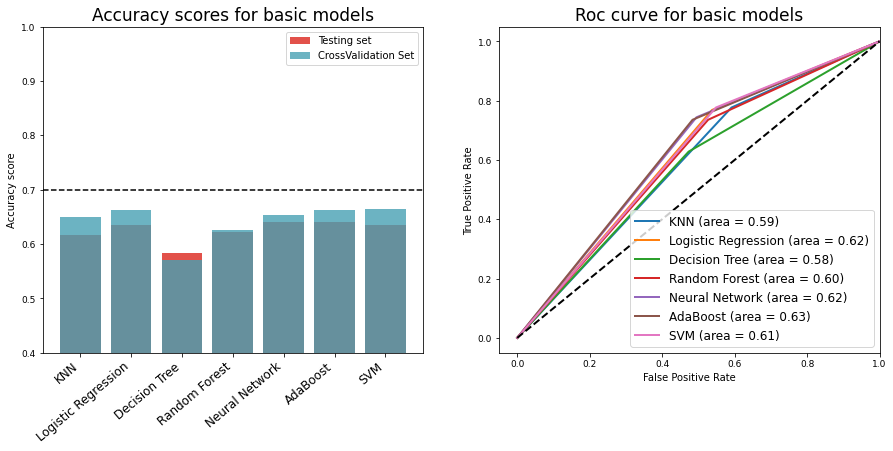

In [75]:
grafico_riassuntivo(knn_train, lg_train, dt_train, rf_train, rn_train, ad_train, svc_train, knn_test, lg_test, dt_test, rf_test, rn_test, ad_test, svc_test, knn_pred, lg_pred, dt_pred, rf_pred, rn_pred, ad_pred, svc_pred)

Grafico a barre : Si creano due liste scores_all e scores_predictive che contengono i punteggi di accuratezza (accuracy scores) ottenuti durante la cross-validation (scores_all) e sui dati di testing (scores_predictive) per ciascun modello.

Si crea un grafico a barre (ax1) che rappresenta i punteggi di accuratezza per tutti i modelli. Le barre "CrossValidation Set" sono tratteggiate ("hatch="x"") e di un colore specifico, mentre le barre "Testing set" sono trasparenti (alpha=0.5) e di un colore diverso.

Curva ROC (Receiver Operating Characteristic): La curva ROC è una rappresentazione grafica delle prestazioni di un modello di classificazione binaria. Mostra la relazione tra la sensibilità (True Positive Rate o TPR) e la specificità (True Negative Rate o TNR) del modello al variare della soglia di decisione. In pratica, la curva ROC mostra come il modello si comporta nella distinzione tra classi positive e negative al variare della soglia. Idealmente, un modello con prestazioni eccellenti avrà una curva ROC che si avvicina al vertice in alto a sinistra del grafico, il che significa una sensibilità elevata e una specificità elevata.

AUC (Area Under the Curve): L'AUC è l'area sottesa alla curva ROC ed è una misura numerica delle prestazioni di un modello di classificazione binaria. L'AUC è compreso tra 0 e 1, dove un valore maggiore indica prestazioni migliori. Un'AUC pari a 1 indica che il modello è in grado di distinguere perfettamente tra classi positive e negative. Un'AUC pari a 0.5 indica che il modello non è migliore di una scelta casuale tra le classi.

Quindi, quando si dice "che mostra le curve ROC e le AUC dei modelli per valutare le loro prestazioni", si sta descrivendo un processo di valutazione delle prestazioni dei modelli di classificazione. Le curve ROC consentono di visualizzare come i modelli si comportano in termini di trade-off tra sensibilità e specificità, mentre l'AUC fornisce un valore numerico che riassume le prestazioni complessive del modello. Un AUC maggiore di 0.5 indica una performance migliore rispetto a un modello casuale, mentre un AUC di 1 indica una performance perfetta. Queste metriche sono spesso utilizzate per confrontare e valutare i modelli di classificazione binaria.

B)Relationship between genetic attributes and outcomes¶

Gli attributi genetici si riferiscono a caratteristiche o tratti che sono influenzati o determinati dal materiale genetico di un individuo. Questo materiale genetico è costituito dal DNA (acido desossiribonucleico) che si trova all'interno delle cellule e contiene le istruzioni per la formazione e il funzionamento di un organismo.
Gli attributi genetici possono influenzare la predisposizione di un individuo a determinate malattie o condizioni mediche. Alcuni esempi includono la suscettibilità a malattie ereditarie come la fibrosi cistica o la talassemia.
Gli attributi genetici sono influenzati dall'interazione tra i geni ereditati dai genitori di un individuo e da fattori ambientali. È importante notare che gli attributi genetici non sono determinati esclusivamente dal DNA, ma possono essere modulati da vari fattori esterni come l'ambiente, lo stile di vita e l'esposizione a fattori di rischio.


In [48]:
df.shape[:]

(854, 693)

In [49]:
#  Eliminiamo le mutazioni
genetic_features_to_drop = df.columns[520:]
genetic_df = df.drop(genetic_features_to_drop, axis=1)
# Eliminiamo i clinical data
genetic_features_to_drop = genetic_df.columns[1:35]
genetic_df = genetic_df.drop(genetic_features_to_drop, axis=1)

genetic_df = genetic_df.iloc [:,:-174]
genetic_df['overall_survival']= df['overall_survival']
genetic_df

patient_id    tp53     atm    cdh1   chek2     nbn     nf1   stk11  \
1              2 -0.0136 -0.2659  1.3594  0.7961  0.5419 -2.6059  0.5120   
4              8  0.3484  0.3897  0.9131  0.9356  0.7675 -0.2940 -0.2961   
5             10 -1.9371  0.9252  1.1520  0.7951 -0.9677 -0.7750 -0.3532   
9             35  0.5314  0.9105 -1.5068 -0.0196  0.3726  0.4892  0.4366   
10            36 -0.6333 -0.6192  0.2709 -0.4980  1.2944  0.1006  0.6121   
...          ...     ...     ...     ...     ...     ...     ...     ...   
1613        6225 -0.5098 -0.8756 -0.5237  1.1626 -0.1726 -0.2473 -1.1045   
1616        6229  0.1319 -1.9487 -0.2028 -0.3374  1.4109  3.1759 -0.7863   
1619        6233  0.1746  2.0361  0.1095  0.1703  0.4698  0.6346 -0.8521   
1623        6239  0.7391 -0.0885 -0.5507  0.2998 -0.1456  0.1503  0.0833   
1664        6346 -0.6177 -0.5362 -0.1910 -1.4707  0.8071 -0.5439 -0.4216   

       bard1    mlh1  ...  tubb4a  tubb4b  twist1  adgra2    afdn    aff2  \
1     0.4390  1.2266  ... -0.1003  0.7791 -0.2273 -0.4462 -1.9854  0.5022   
4     0.6320 -0.3582  ... -0.6606 -1.4697  0.4128 -1.5326 -0.4795  1.0052   
5     1.0599 -0.2754  ... -0.2737  0.3531  0.2687 -0.1279 -0.1615  0.4695   
9     0.6445 -0.0810  ... -0.8030 -0.0882 -0.9817 -1.6599  0.7921 -1.2108   
10   -0.7947  1.7251  ... -0.4204  0.9419  0.0528 -0.0410  0.7902  1.5006   
...      ...     ...  ...     ...     ...     ...     ...     ...     ...   
1613 -1.2084  0.5817  ... -0.7659 -2.1043 -0.0938  0.6294  0.2733 -0.6332   
1616  0.1634  0.7951  ...  0.3093  0.0452  0.1145  0.3805 -1.7684 -0.4573   
1619 -0.5567  0.4383  ... -1.3219  0.0969 -0.1218  1.3610 -1.4110 -0.3789   
1623  0.0243  0.5095  ... -0.1783 -0.3734  0.0637  1.2888 -1.8245 -0.4734   
1664  0.9720 -1.4268  ... -0.7407  0.9520 -0.8625 -1.2410  0.2442 -0.6247   

        agmo   agtr2   ahnak  overall_survival  
1    -0.9526 -1.8435  1.6662                 1  
4     0.9739  0.8825 -0.7598                 0  
5    -1.5671 -1.1999  0.3160                 0  
9    -0.5101  0.3393  0.7747                 0  
10    1.2647  0.1172  0.0746                 0  
...      ...     ...     ...               ...  
1613 -0.4215  0.3744  0.3902                 1  
1616 -1.1672 -0.7894  1.6029                 0  
1619  0.0631 -0.0149  0.1031                 1  
1623 -0.1906 -0.7146  0.5374                 1  
1664  0.8078 -2.0027 -0.0259                 1  

[854 rows x 313 columns]

In [50]:
genetic_df.shape[:]

(854, 313)

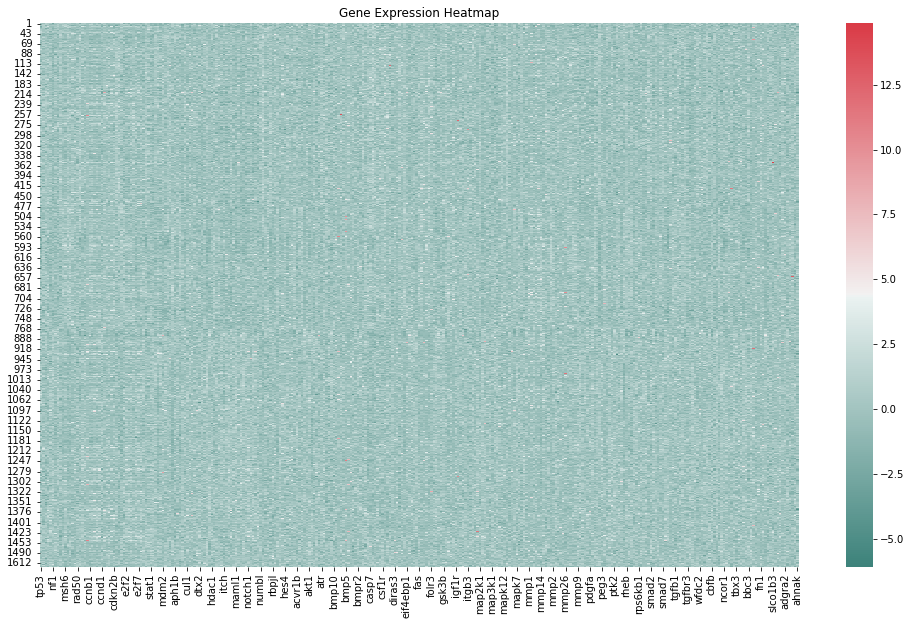

In [51]:
# Visualizing the mRNA values in a heatmap.
fig, axs = plt.subplots(figsize = (17, 10))
sns.heatmap(genetic_df.drop(['patient_id','overall_survival'], axis=1), ax = axs, cmap = sns.diverging_palette(180, 10, as_cmap = True))
plt.title('Gene Expression Heatmap')

plt.show()

TP53, ATM e CDH1 sono geni umani che svolgono importanti ruoli nel normale funzionamento delle cellule e possono essere associati a malattie o condizioni genetiche specifiche.

TP53: TP53, noto anche come gene p53, è un gene supressore dei tumori che svolge un ruolo chiave nella prevenzione della crescita tumorale. È coinvolto nella regolazione del ciclo cellulare, riparazione del DNA e apoptosi (morte cellulare programmata). Le mutazioni nel gene TP53 sono associate a una predisposizione ereditaria ai tumori, come la sindrome di Li-Fraumeni, e sono comuni in molti tipi di cancro.

ATM: ATM (Ataxia Telangiectasia Mutated) è un gene coinvolto nella riparazione del DNA e nella regolazione delle risposte cellulari allo stress da danni al DNA. Le mutazioni nel gene ATM sono associate alla sindrome di Atassia Telangiectasia (AT), una malattia genetica rara caratterizzata da disturbi neurologici, compromissione del sistema immunitario e una maggiore suscettibilità al cancro.

CDH1: CDH1 è il gene che codifica la proteina E-caderina, che è coinvolta nella coesione cellulare e nell'adesione tra le cellule epiteliali. Mutazioni nel gene CDH1 sono associate a una condizione chiamata sindrome di ereditaria di carcinoma lobulare del seno (HDGC, Hereditary Diffuse Gastric Cancer). Questa sindrome aumenta il rischio di sviluppare il carcinoma lobulare del seno e il carcinoma gastrico diffuso.

CHEK2: CHEK2 (Checkpoint kinase 2) è un gene coinvolto nella regolazione del ciclo cellulare e nella risposta al DNA danneggiato. Mutazioni nel gene CHEK2 possono essere associate ad un aumentato rischio di sviluppare il cancro al seno, al colon, alla prostata e ad altri tipi di tumori.

NBN: NBN (Nibrin) è un gene coinvolto nella riparazione del DNA e nella stabilità genomica. Mutazioni nel gene NBN possono essere associate alla sindrome di Nijmegen, una malattia genetica rara caratterizzata da anomalie dello sviluppo, immunodeficienza e un aumentato rischio di cancro.

NF1: NF1 (Neurofibromin 1) è un gene che produce la proteina neurofibromina, coinvolta nella regolazione della crescita delle cellule nervose. Mutazioni nel gene NF1 sono associate alla neurofibromatosi di tipo 1 (NF1), una malattia genetica che causa la formazione di tumori benigni sulla pelle e nel sistema nervoso.

STK11: STK11 (Serine/Threonine Kinase 11), noto anche come gene LKB1, è coinvolto nella regolazione del ciclo cellulare e nella supressione tumorale. Mutazioni nel gene STK11 sono associate alla sindrome di Peutz-Jeghers (PJS), una condizione caratterizzata dalla formazione di polipi intestinali e la predisposizione a tumori benigni e maligni in diverse parti del corpo.

BARD1: BARD1 (BRCA1 Associated RING Domain 1) è un gene coinvolto nella riparazione del DNA e nella regolazione della crescita cellulare. È associato al gene BRCA1 ed è coinvolto nel mantenimento della stabilità genomica. Mutazioni nel gene BARD1 possono essere associate a un aumentato rischio di sviluppare il cancro al seno e all'ovaio.

MLH1: MLH1 (MutL Homolog 1) è un gene coinvolto nella riparazione del DNA e nella stabilità genomica. È coinvolto nel processo di correzione degli errori del DNA durante la replicazione cellulare. Mutazioni nel gene MLH1 sono associate alla sindrome di Lynch, una condizione ereditaria che aumenta il rischio di sviluppare tumori del colon, dell'utero e di altri organi.

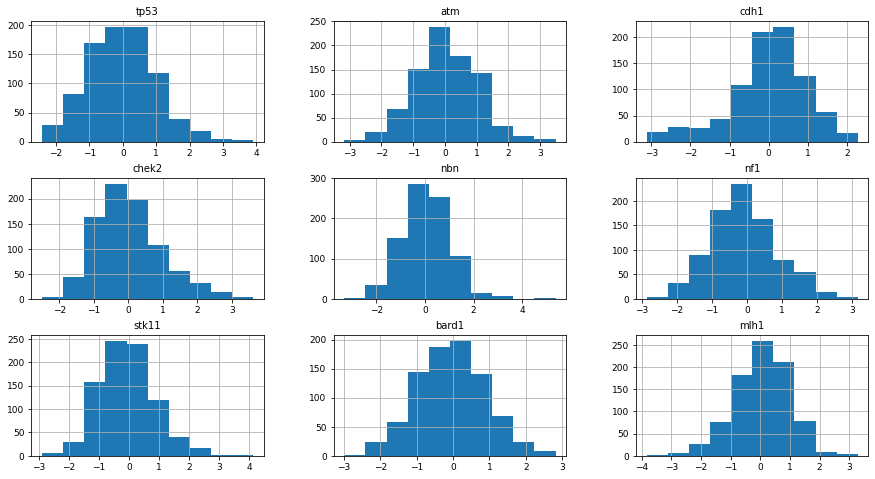

In [52]:
params = {'axes.titlesize':'10',
          'xtick.labelsize':'9',
          'ytick.labelsize':'9'}
matplotlib.rcParams.update(params)
#plt.subplots_adjust(hspace=0.5)
genetic_df.drop(['patient_id','overall_survival'], axis=1).iloc[:,:9].hist(figsize=(15,8))
plt.show()

#Gli istogrammi rappresentano la distribuzione dei valori all'interno di ciascuna colonna selezionata.
#L'asse x dell'istogramma rappresenta gli intervalli di valori per la colonna selezionata,
#mentre l'asse y rappresenta la frequenza di occorrenza di valori all'interno di ciascun intervallo.
#Quindi, per ciascuna delle colonne specificate, verrà visualizzato un istogramma che mostra come i
#valori sono distribuiti all'interno di quella colonna specifica. Questo può fornire informazioni
#sulla variabilità, la concentrazione o la forma della distribuzione dei valori per ciascuna colonna.



/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

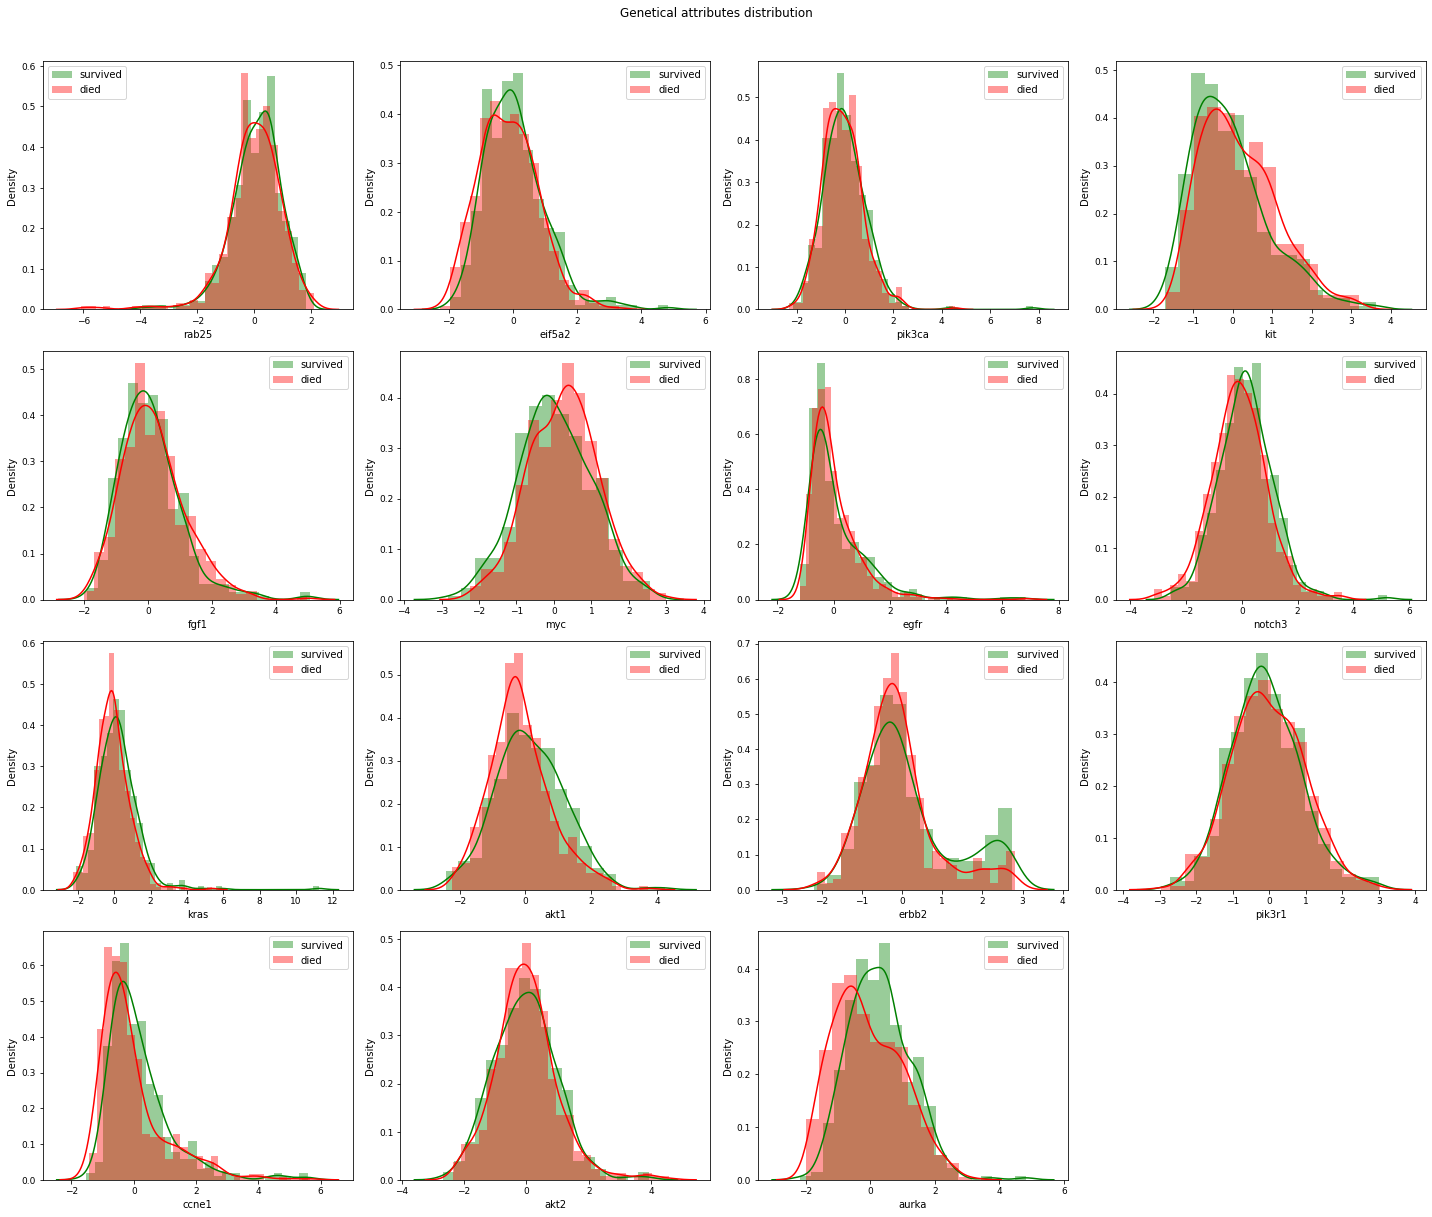

In [53]:
fig = plt.figure(figsize = (20, 25))
j = 0

gene_list = ['rab25', 'eif5a2', 'pik3ca', 'kit', 'fgf1', 'myc', 'egfr', 'notch3', 'kras', 'akt1', 'erbb2', 'pik3r1', 'ccne1', 'akt2', 'aurka']
for i in genetic_df.drop(['patient_id'], axis=1).loc[:,gene_list].columns:
    plt.subplot(6, 4, j+1)
    j += 1
    sns.distplot(genetic_df[i][genetic_df['overall_survival']==0], color='g', label = 'survived')
    sns.distplot(genetic_df[i][genetic_df['overall_survival']==1], color='r', label = 'died')
    plt.legend(loc='best')
fig.suptitle('Genetical attributes distribution')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()



All of the attributes have relatively the same distribution shape for two classes (survival and dead)


Text(0.5, 1.0, 'Histogram of Correlation of genes with the survival')

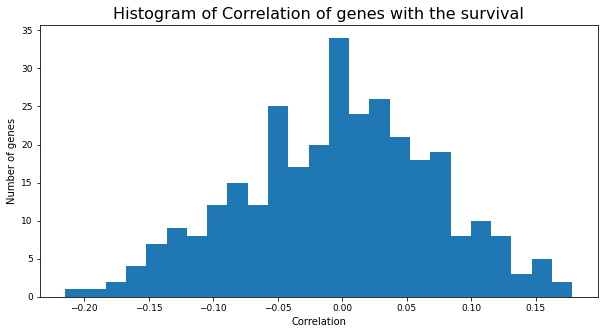

In [54]:
#quanto sono vari i geni e quanto bene si correlano con gli eventi di morte?
fig, ax = plt.subplots(figsize = (10,5))
#traccia l'istogramma della variazione utilizzando la deviazione standard come misura
corrs=[]
for col in genetic_df.drop(['patient_id'], axis = 1).columns:
    corr = genetic_df[[col,'overall_survival']].corr()['overall_survival'][col]
    corrs.append(corr)
    #['overall_survival'][col]: Successivamente, viene utilizzata la doppia indicizzazione
    #per estrarre il valore specifico di correlazione tra le due colonne.
     #['overall_survival'] indica che stiamo selezionando la riga corrispondente alla colonna
     #'overall_survival' dalla matrice di correlazione.[col] indica che stiamo selezionando la
     #colonna specifica, che rappresenta il gene corrente, dalla riga selezionata.

corrs.pop(-1)
ax.hist(corrs,  bins=25)
ax.set_xlabel("Correlation")
ax.set_ylabel("Number of genes")
ax.set_title("Histogram of Correlation of genes with the survival", size=16)
# L'asse x dell'istogramma rappresenta i valori di correlazione con la sopravvivenza,
#mentre l'asse y rappresenta il numero di geni che presentano una determinata correlazione.
#Questo può fornire un'indicazione della variazione dei geni e della loro associazione
#con l'evento di sopravvivenza.

In [55]:
#Max, min and mean of correlation
print("Maximum Correlation: " + "%.3f" %max(corrs))
print("Minimum Correlation: " + "%.3f" %min(corrs))
print("Mean Correlation: " + "%.3f" %np.mean(corrs))

Maximum Correlation: 0.178
Minimum Correlation: -0.215
Mean Correlation: -0.003


La maggior parte degli attributi ha una correlazione molto debole con gli attributi target

Classification with only genetic attributes




In [56]:
# data splitting
X = genetic_df.drop(['overall_survival'], axis=1)
y = genetic_df['overall_survival']

X_train, X_test, y_train, y_test = train_test_split(to_standard(X), y, stratify = y, random_state = 42)

In [57]:
X_train.shape[:] #ho 312 features

(640, 312)

In [58]:
#LOGISTIC REGRESSION (Senza GridSearchCV perchè ci impiega troppo tempo)
print("LOGISTIC REGRESSION")
logistic_regression = LogisticRegression(random_state=42, max_iter=2000)
lg_pred, lg_test, lg_train = metrics(logistic_regression, X_train, X_test, y_train, y_test, 4)

#DECISION TREE
print("DECISION TREE")
dec_tree_clf = tree.DecisionTreeClassifier()
dt_pred, dt_test, dt_train = metrics(dec_tree_clf, X_train, X_test, y_train, y_test, 4)

#RETE NEURALE
print("NEURAL NETWORK")
params = {
    'solver': ['lbfgs', 'sgd', 'adam'],
    'activation': ['logistic', 'tanh', 'relu']
}
MLP_clf = GridSearchCV(MLPClassifier(alpha=1e-5, hidden_layer_sizes=(10, 7, 2), max_iter=10000, random_state=42), params, n_jobs=-1, cv=5)
rn_pred, rn_test, rn_train = metrics(MLP_clf, X_train, X_test, y_train, y_test, 4)

#KNN
print("KNN")
params = {
    "n_neighbors" : [5,15,25,30,35,40, 100],
    "weights" : ["uniform" , "distance"]
    }
    #Under some circumstances, it is better to weight the neighbors such that nearer neighbors
    #contribute more to the fit. This can be accomplished through the weights
    #keyword. The default value, weights = 'uniform', assigns uniform
    #weights to each neighbor. weights = 'distance' assigns weights proportional
    #to the inverse of the distance from the query point.

clf_neighbors = GridSearchCV(neighbors.KNeighborsClassifier(), params, n_jobs = -1, cv = 4)
knn_pred, knn_test, knn_train = metrics(clf_neighbors, X_train, X_test, y_train, y_test, 4)

#Random forest
print("RANDOM FOREST")
cl_random_forest = RandomForestClassifier(random_state=42)
rf_pred, rf_test, rf_train = metrics(cl_random_forest, X_train, X_test, y_train, y_test, 4)

#Adaboost
print("ADABOOST")
ada_boost = AdaBoostClassifier(random_state=42)
ad_pred, ad_test, ad_train = metrics(ada_boost, X_train, X_test, y_train, y_test, 4)

#SVM
print("SVM")
clf_linearsvc = svm.LinearSVC(max_iter=20000)
svc_pred, svc_test, svc_train = metrics(clf_linearsvc, X_train, X_test, y_train, y_test, 4)

LOGISTIC REGRESSION
CV scores:  [0.525   0.48125 0.54375 0.50625]
CV Standard Deviation:  0.023122888417107395
CV Mean score:  0.5140625

Train score:  0.890625
Test score/Accuratezza del modello:  0.5794392523364486

Precision: 0.6220472440944882
Recall: 0.6528925619834711
Matrice di confusione :
[[45 48]
 [42 79]]

DECISION TREE
CV scores:  [0.53125 0.55    0.55    0.5    ]
CV Standard Deviation:  0.020432338797846925
CV Mean score:  0.5328125

Train score:  1.0
Test score/Accuratezza del modello:  0.5327102803738317

Precision: 0.584
Recall: 0.6033057851239669
Matrice di confusione :
[[41 52]
 [48 73]]

NEURAL NETWORK
CV scores:  [0.575   0.4875  0.59375 0.5375 ]
CV Standard Deviation:  0.040594940802395556
CV Mean score:  0.5484375

Train score:  0.7890625
Test score/Accuratezza del modello:  0.6401869158878505

Precision: 0.7075471698113207
Recall: 0.6198347107438017
Matrice di confusione :
[[62 31]
 [46 75]]

KNN
CV scores:  [0.6125  0.64375 0.5875  0.54375]
CV Standard Deviation

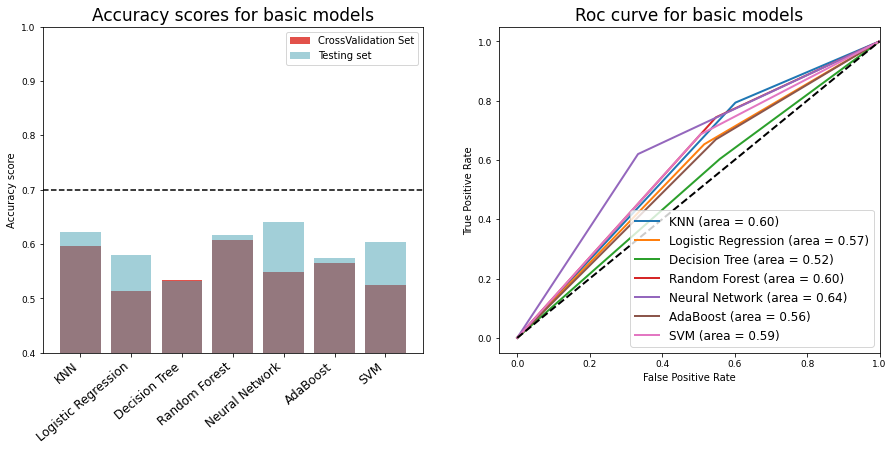

In [59]:
grafico_riassuntivo(knn_train, lg_train, dt_train, rf_train, rn_train, ad_train, svc_train, knn_test, lg_test, dt_test, rf_test, rn_test, ad_test, svc_test, knn_pred, lg_pred, dt_pred, rf_pred, rn_pred, ad_pred, svc_pred)

Prestazioni un pò scadenti, proviamo a migliorare effettuando una feature selection.
regressor = LogisticRegression(): Viene creato un oggetto LogisticRegression, che rappresenta il modello di regressione logistica. Questo sarà il modello che verrà utilizzato per valutare l'importanza delle feature durante il processo di eliminazione ricorsiva delle feature.

feature_selector = RFECV(regressor): Viene creato un oggetto RFECV (Recursive Feature Elimination with Cross-Validation) utilizzando il modello regressor come stimatore. RFECV è una tecnica che esegue la feature selection eliminando iterativamente le feature meno informative e utilizzando la validazione incrociata per valutare l'impatto delle feature rimosse sulle prestazioni del modello.

fit = feature_selector.fit(X, y): Il modello RFECV viene adattato (fit) ai dati X (le feature) e y (il target o l'etichetta). Durante questo processo, RFECV eseguirà la selezione delle feature in modo iterativo.

optimal_feature_count = feature_selector.n_features_: Dopo aver adattato RFECV ai dati, è possibile ottenere il numero ottimale di feature selezionate utilizzando il modello. Questo valore rappresenta il numero di feature che RFECV ha selezionato come le più informative durante il processo di eliminazione ricorsiva.

X_new = X.loc[:, feature_selector.get_support()]: Alla fine del processo, X_new conterrà solo le feature selezionate da RFECV come le più informative. feature_selector.get_support() restituirà un array di booleani che indica quali feature sono state selezionate. X.loc[:, feature_selector.get_support()] selezionerà solo le colonne corrispondenti alle feature selezionate nel DataFrame X.

print(X_new.columns): Questo comando stampa i nomi delle colonne del DataFrame X_new, che rappresentano le feature selezionate dopo il processo di feature selection.

In breve, il codice utilizza RFECV con un modello di regressione logistica per identificare le feature più informative e restituisce un DataFrame X_new contenente solo queste feature selezionate.


In [60]:
regressor = LogisticRegression(max_iter = 1000)
feature_selector = RFECV(regressor)

fit = feature_selector.fit(X_train,y_train)

optimal_feature_count = feature_selector.n_features_
print(f"Optimal numer of features: {optimal_feature_count}")

X_new = X_train.loc[:, feature_selector.get_support()]
print(X_new.columns)

Optimal numer of features: 12
Index(['chek2', 'stk11', 'mlh1', 'pms2', 'cdk1', 'cdkn2a', 'stat5a', 'notch2',
       'gsk3b', 'igf1r', 'rps6ka2', 'bbc3'],
      dtype='object')


In [61]:
X_test_new = X_test[X_new.columns]

In [62]:
X_test_new.shape[:]

(214, 12)

In [65]:
#LOGISTIC REGRESSION (Senza GridSearchCV perchè ci impiega troppo tempo)
print("LOGISTIC REGRESSION")
logistic_regression = LogisticRegression(random_state=42, max_iter=2000)
lg_pred, lg_test, lg_train = metrics(logistic_regression, X_new, X_test_new, y_train, y_test, 4)

#DECISION TREE
print("DECISION TREE")
dec_tree_clf = tree.DecisionTreeClassifier()
dt_pred, dt_test, dt_train = metrics(dec_tree_clf, X_new, X_test_new, y_train, y_test, 4)

#RETE NEURALE
print("NEURAL NETWORK")
params = {
    'solver': ['sgd', 'adam'],
    'activation': ['logistic', 'tanh', 'relu']
}
MLP_clf = GridSearchCV(MLPClassifier(alpha=1e-5, hidden_layer_sizes=(10, 7, 2), max_iter = 80000, random_state=42), params, n_jobs=-1, cv=5)
rn_pred, rn_test, rn_train = metrics(MLP_clf, X_new, X_test_new, y_train, y_test, 4)

#KNN
print("KNN")
params = {
    "n_neighbors" : [5,15,25,30,35,40, 100],
    "weights" : ["uniform" , "distance"]
    }
    #Under some circumstances, it is better to weight the neighbors such that nearer neighbors
    #contribute more to the fit. This can be accomplished through the weights
    #keyword. The default value, weights = 'uniform', assigns uniform
    #weights to each neighbor. weights = 'distance' assigns weights proportional
    #to the inverse of the distance from the query point.

clf_neighbors = GridSearchCV(neighbors.KNeighborsClassifier(), params, n_jobs = -1, cv = 4)
knn_pred, knn_test, knn_train = metrics(clf_neighbors, X_new, X_test_new, y_train, y_test, 4)

#Random forest
print("RANDOM FOREST")
cl_random_forest = RandomForestClassifier(random_state=42)
rf_pred, rf_test, rf_train = metrics(cl_random_forest, X_new, X_test_new, y_train, y_test, 4)

#Adaboost
print("ADABOOST")
ada_boost = AdaBoostClassifier(random_state=42)
ad_pred, ad_test, ad_train = metrics(ada_boost, X_new, X_test_new, y_train, y_test, 4)

#SVM
print("SVM")
clf_linearsvc = svm.LinearSVC(max_iter=20000)
svc_pred, svc_test, svc_train = metrics(clf_linearsvc, X_new, X_test_new, y_train, y_test, 4)


LOGISTIC REGRESSION
CV scores:  [0.65625 0.7     0.66875 0.625  ]
CV Standard Deviation:  0.026882266459508194
CV Mean score:  0.6625

Train score:  0.7015625
Test score/Accuratezza del modello:  0.6355140186915887

Precision: 0.6503496503496503
Recall: 0.768595041322314
Matrice di confusione :
[[43 50]
 [28 93]]

DECISION TREE
CV scores:  [0.55    0.56875 0.55    0.6125 ]
CV Standard Deviation:  0.0255314603724503
CV Mean score:  0.5703125

Train score:  1.0
Test score/Accuratezza del modello:  0.5841121495327103

Precision: 0.6333333333333333
Recall: 0.628099173553719
Matrice di confusione :
[[49 44]
 [45 76]]

NEURAL NETWORK
CV scores:  [0.6875 0.6625 0.6375 0.625 ]
CV Standard Deviation:  0.024003580462089405
CV Mean score:  0.653125

Train score:  0.6765625
Test score/Accuratezza del modello:  0.6401869158878505

Precision: 0.6617647058823529
Recall: 0.743801652892562
Matrice di confusione :
[[47 46]
 [31 90]]

KNN
CV scores:  [0.675   0.65    0.69375 0.58125]
CV Standard Deviatio

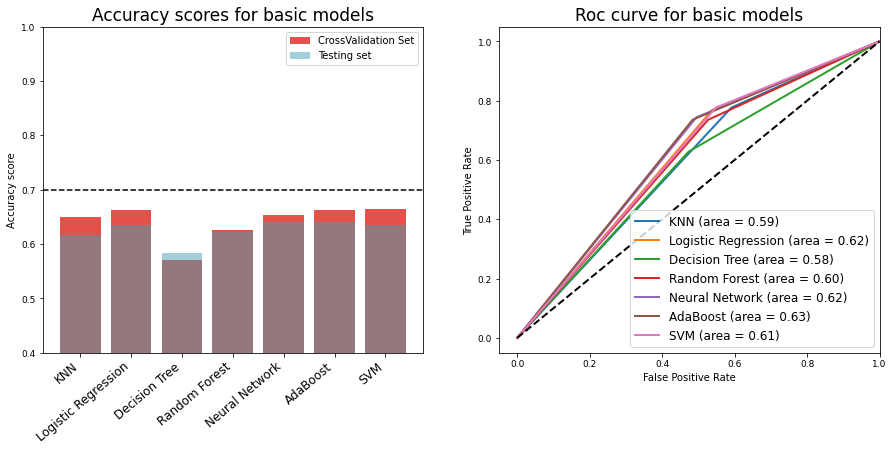

In [66]:
grafico_riassuntivo(knn_train, lg_train, dt_train, rf_train, rn_train, ad_train, svc_train, knn_test, lg_test, dt_test, rf_test, rn_test, ad_test, svc_test, knn_pred, lg_pred, dt_pred, rf_pred, rn_pred, ad_pred, svc_pred)

Proviamo con altre tecniche: La PCA è una tecnica di riduzione delle dimensioni dei dati che mira a semplificare un dataset mantenendo le informazioni più importanti e significative. Ecco come funziona in modo più dettagliato:

Identificazione delle componenti principali (Principal Components):

La PCA inizia identificando le "componenti principali" nei dati. Queste componenti sono delle combinazioni lineari delle feature originali che catturano la massima varianza nei dati.
La prima componente principale rappresenta la direzione lungo la quale i dati variano di più. È progettata in modo da catturare la massima varianza nei dati.
Le successive componenti principali vengono selezionate in modo che siano ortogonali (indipendenti) rispetto alle componenti precedenti e catturino la varianza residua nei dati.
Riduzione della dimensionalità:

Una volta identificate le componenti principali, è possibile selezionare un numero inferiore di queste componenti per rappresentare i dati in modo più compatto. Questa scelta dipende dall'obiettivo dell'analisi.
Ad esempio, se hai un dataset iniziale con molte feature (ad esempio, 100) ma scopri che le prime due o tre componenti principali catturano la maggior parte della varianza nei dati, puoi scegliere di utilizzare solo queste due o tre componenti per rappresentare il dataset.
Riduzione del rumore e semplificazione:

La PCA aiuta a ridurre il rumore nei dati. Rimuovendo le componenti con varianza bassa, è possibile eliminare il rumore o le informazioni irrilevanti, migliorando così la qualità delle analisi e dei modelli successivi.
Inoltre, la PCA semplifica i dati, consentendo una comprensione più chiara delle relazioni tra le feature e semplificando le visualizzazioni.
La PCA è ampiamente utilizzata in molte applicazioni, tra cui analisi dei dati, riduzione del rumore, compressione dei dati, visualizzazione dei dati, riconoscimento dei pattern e molto altro. È una tecnica potente per esplorare, semplificare e analizzare dataset complessi.

Un aspetto importante della PCA è la capacità di scegliere il numero di componenti principali da utilizzare in base agli obiettivi specifici. Questa scelta può essere basata sulla varianza spiegata (quanta varianza viene catturata da ciascuna componente principale) o su criteri specifici del problema.


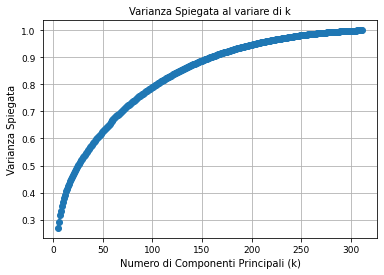

In [76]:
# Range di valori di k (numero di componenti principali)
k_values = range(5, len(X.columns))  # Esempio: da 5 a 311 componenti principali

# Esegui PCA con diversi valori di k
explained_variances = []

for k in k_values:
    pca = PCA(n_components=k)
    X_pca = pca.fit_transform(to_standard(X))
    explained_variances.append(np.sum(pca.explained_variance_ratio_))

# Visualizza la varianza spiegata al variare di k
plt.plot(k_values, explained_variances, marker='o')
plt.xlabel('Numero di Componenti Principali (k)')
plt.ylabel('Varianza Spiegata')
plt.title('Varianza Spiegata al variare di k')
plt.grid(True)
plt.show()

Osserva il grafico della varianza spiegata in funzione di k. Cerca il punto in cui la varianza spiegata smette di crescere in modo significativo e inizia a livellarsi. Questo è un suggerimento per selezionare k.

In [77]:
pca = PCA(n_components=230)
X_pca = pca.fit_transform(X_train, y_train)
X_test_new = pca.transform(X_test)

#X_train, X_test, y_train, y_test = train_test_split(X_pca, y, random_state=42, stratify = y)

In [78]:
#LOGISTIC REGRESSION (Senza GridSearchCV perchè ci impiega troppo tempo)
print("LOGISIC REGRESSION")
logistic_regression = LogisticRegression(random_state=42, max_iter=2000)
lg_pred, lg_test, lg_train = metrics(logistic_regression, X_pca, X_test_new, y_train, y_test, 4)

#DECISION TREE
print("DECISION TREE")
dec_tree_clf = tree.DecisionTreeClassifier()
dt_pred, dt_test, dt_train = metrics(dec_tree_clf, X_pca, X_test_new, y_train, y_test, 4)

#RETE NEURALE
print("NEURAL NETWORK")
params = {
    'solver': ['lbfgs', 'sgd', 'adam'],
    'activation': ['logistic', 'tanh', 'relu']
}
MLP_clf = GridSearchCV(MLPClassifier(alpha=1e-5, hidden_layer_sizes=(10, 7, 2), max_iter = 10000, random_state=42), params, n_jobs=-1, cv=5)
rn_pred, rn_test, rn_train = metrics(MLP_clf, X_pca, X_test_new, y_train, y_test, 4)

#KNN
print("KNN")
params = {
    "n_neighbors" : [5,15,25,30,35,40, 100],
    "weights" : ["uniform" , "distance"]
    }
    #Under some circumstances, it is better to weight the neighbors such that nearer neighbors
    #contribute more to the fit. This can be accomplished through the weights
    #keyword. The default value, weights = 'uniform', assigns uniform
    #weights to each neighbor. weights = 'distance' assigns weights proportional
    #to the inverse of the distance from the query point.

clf_neighbors = GridSearchCV(neighbors.KNeighborsClassifier(), params, n_jobs = -1, cv = 4)
knn_pred, knn_test, knn_train = metrics(clf_neighbors, X_pca, X_test_new, y_train, y_test, 4)

#Random forest
print("RANDOM FOREST")
cl_random_forest = RandomForestClassifier(random_state=42)
rf_pred, rf_test, rf_train = metrics(cl_random_forest, X_pca, X_test_new, y_train, y_test, 4)

#Adaboost
print("ADABOOST")
ada_boost = AdaBoostClassifier(random_state=42)
ad_pred, ad_test, ad_train = metrics(ada_boost, X_pca, X_test_new, y_train, y_test, 4)

#SVM
print("SVM")
clf_linearsvc = svm.LinearSVC(max_iter=20000)
svc_pred, svc_test, svc_train = metrics(clf_linearsvc, X_pca, X_test_new, y_train, y_test, 4)


LOGISIC REGRESSION
CV scores:  [0.5625  0.48125 0.51875 0.54375]
CV Standard Deviation:  0.0304186286467684
CV Mean score:  0.5265625

Train score:  0.81875
Test score/Accuratezza del modello:  0.6448598130841121

Precision: 0.6717557251908397
Recall: 0.7272727272727273
Matrice di confusione :
[[50 43]
 [33 88]]

DECISION TREE
CV scores:  [0.525   0.55625 0.5625  0.56875]
CV Standard Deviation:  0.01682864002229531
CV Mean score:  0.553125

Train score:  1.0
Test score/Accuratezza del modello:  0.5093457943925234

Precision: 0.5666666666666667
Recall: 0.5619834710743802
Matrice di confusione :
[[41 52]
 [53 68]]

NEURAL NETWORK
CV scores:  [0.56875 0.5375  0.59375 0.54375]
CV Standard Deviation:  0.02226219820121096
CV Mean score:  0.5609375

Train score:  1.0
Test score/Accuratezza del modello:  0.5794392523364486

Precision: 0.6148148148148148
Recall: 0.6859504132231405
Matrice di confusione :
[[41 52]
 [38 83]]

KNN
CV scores:  [0.60625 0.63125 0.58125 0.56875]
CV Standard Deviation

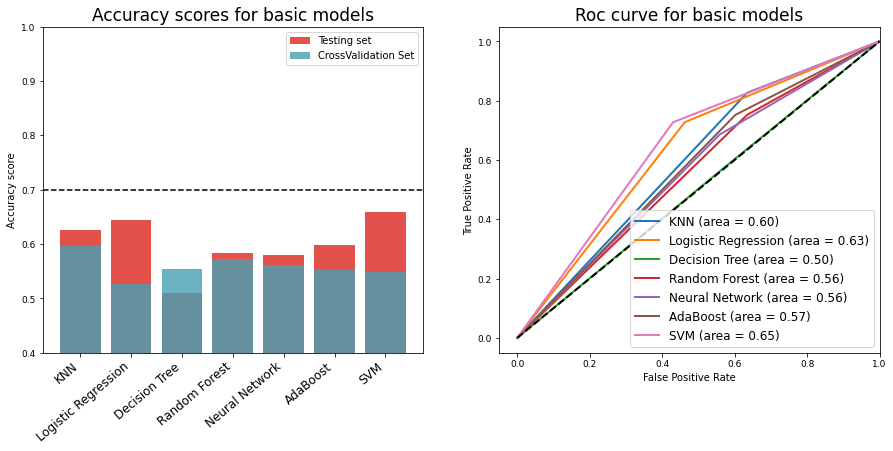

In [79]:
grafico_riassuntivo(knn_train, lg_train, dt_train, rf_train, rn_train, ad_train, svc_train, knn_test, lg_test, dt_test, rf_test, rn_test, ad_test, svc_test, knn_pred, lg_pred, dt_pred, rf_pred, rn_pred, ad_pred, svc_pred)

Selezione basata su statistiche:
Utilizzare test statistici come l'ANOVA (Analysis of Variance) o il test chi-quadrato per valutare la rilevanza delle feature rispetto al target.
Scikit-learn fornisce la classe SelectKBest per selezionare le prime K feature basate su un test di significatività.
score_func=f_classif è un parametro utilizzato nella classe SelectKBest di scikit-learn per specificare quale funzione
di scoring o test statistico deve essere utilizzata per valutare la rilevanza delle feature nel contesto di una
classificazione (classification task). In questo caso, f_classif è una delle opzioni disponibili per il calcolo
del punteggio di rilevanza delle feature.

f_classif rappresenta il test F di ANOVA (Analysis of Variance), che è utilizzato per valutare se ci sono
differenze significative nelle medie dei valori delle feature tra le diverse classi o categorie di un problema di
classificazione. Il punteggio restituito da f_classif misura quanto le feature siano informative per distinguere
le diverse classi nel dataset.

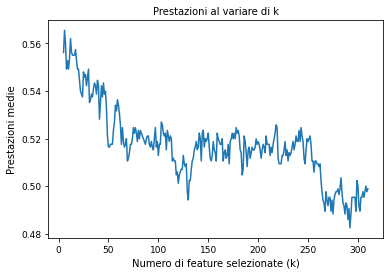

BEST K:  6


In [82]:
# Crea un grafico delle prestazioni per valori di k da 5 a 311
k_values = range(5, len(X.columns) - 1)
scores = []

#Uso come classificatore:
#dec_tree_clf = tree.DecisionTreeClassifier()
clf = LogisticRegression(random_state=42, max_iter=4000)

max = 0
best_K = 0
for k in k_values:
    selector = SelectKBest(score_func=f_classif, k=k)
    pipeline = Pipeline([('selector', selector), ('classifier', clf)])
    cv_scores = cross_val_score(pipeline, to_standard(X), y, cv=5)  # Esempio di 5-fold cross-validation
    scores.append(cv_scores.mean())
    if max < cv_scores.mean():
      max = cv_scores.mean()
      best_K = k

plt.plot(k_values, scores)
plt.xlabel('Numero di feature selezionate (k)')
plt.ylabel('Prestazioni medie')
plt.title('Prestazioni al variare di k')
plt.show()
print("BEST K: ", best_K)


In [83]:
selector = SelectKBest(score_func=f_classif, k=best_K)
X_new = selector.fit_transform(X_train, y_train)
X_test_new = selector.transform(X_test)

#X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=42, stratify = y)

In [84]:
#LOGISTIC REGRESSION (Senza GridSearchCV perchè ci impiega troppo tempo)
print("LOGISIC REGRESSION")
logistic_regression = LogisticRegression(random_state=42, max_iter=2000)
lg_pred, lg_test, lg_train = metrics(logistic_regression, X_new, X_test_new, y_train, y_test, 4)

#DECISION TREE
print("DECISION TREE")
dec_tree_clf = tree.DecisionTreeClassifier()
dt_pred, dt_test, dt_train = metrics(dec_tree_clf, X_new, X_test_new, y_train, y_test, 4)

#RETE NEURALE
print("NEURAL NETWORK")
params = {
    'solver': ['sgd', 'adam'],
    'activation': ['logistic', 'tanh', 'relu']
}
MLP_clf = GridSearchCV(MLPClassifier(alpha=1e-5, hidden_layer_sizes=(10, 7, 2), max_iter = 100000, random_state=42), params, n_jobs=-1, cv=5)
rn_pred, rn_test, rn_train = metrics(MLP_clf, X_new, X_test_new, y_train, y_test, 4)

#KNN
print("KNN")
params = {
    "n_neighbors" : [5,15,25,30,35,40, 100],
    "weights" : ["uniform" , "distance"]
    }
    #Under some circumstances, it is better to weight the neighbors such that nearer neighbors
    #contribute more to the fit. This can be accomplished through the weights
    #keyword. The default value, weights = 'uniform', assigns uniform
    #weights to each neighbor. weights = 'distance' assigns weights proportional
    #to the inverse of the distance from the query point.

clf_neighbors = GridSearchCV(neighbors.KNeighborsClassifier(), params, n_jobs = -1, cv = 4)
knn_pred, knn_test, knn_train = metrics(clf_neighbors, X_new, X_test_new, y_train, y_test, 4)

#Random forest
print("RANDOM FOREST")
cl_random_forest = RandomForestClassifier(random_state=42)
rf_pred, rf_test, rf_train = metrics(cl_random_forest, X_new, X_test_new, y_train, y_test, 4)

#Adaboost
print("ADABOOST")
ada_boost = AdaBoostClassifier(random_state=42)
ad_pred, ad_test, ad_train = metrics(ada_boost, X_new, X_test_new, y_train, y_test, 4)

#SVM
print("SVM")
clf_linearsvc = svm.LinearSVC(max_iter=20000)
svc_pred, svc_test, svc_train = metrics(clf_linearsvc, X_new, X_test_new, y_train, y_test, 4)


LOGISIC REGRESSION
CV scores:  [0.6  0.65 0.65 0.6 ]
CV Standard Deviation:  0.025000000000000022
CV Mean score:  0.625

Train score:  0.6265625
Test score/Accuratezza del modello:  0.6261682242990654

Precision: 0.6394557823129252
Recall: 0.7768595041322314
Matrice di confusione :
[[40 53]
 [27 94]]

DECISION TREE
CV scores:  [0.56875 0.5375  0.5625  0.525  ]
CV Standard Deviation:  0.01788362990978061
CV Mean score:  0.5484375

Train score:  1.0
Test score/Accuratezza del modello:  0.514018691588785

Precision: 0.5702479338842975
Recall: 0.5702479338842975
Matrice di confusione :
[[41 52]
 [52 69]]

NEURAL NETWORK
CV scores:  [0.59375 0.6375  0.58125 0.58125]
CV Standard Deviation:  0.023122888417107374
CV Mean score:  0.5984375

Train score:  0.615625
Test score/Accuratezza del modello:  0.5841121495327103

Precision: 0.5963855421686747
Recall: 0.8181818181818182
Matrice di confusione :
[[26 67]
 [22 99]]

KNN
CV scores:  [0.58125 0.6375  0.6     0.58125]
CV Standard Deviation:  0.0

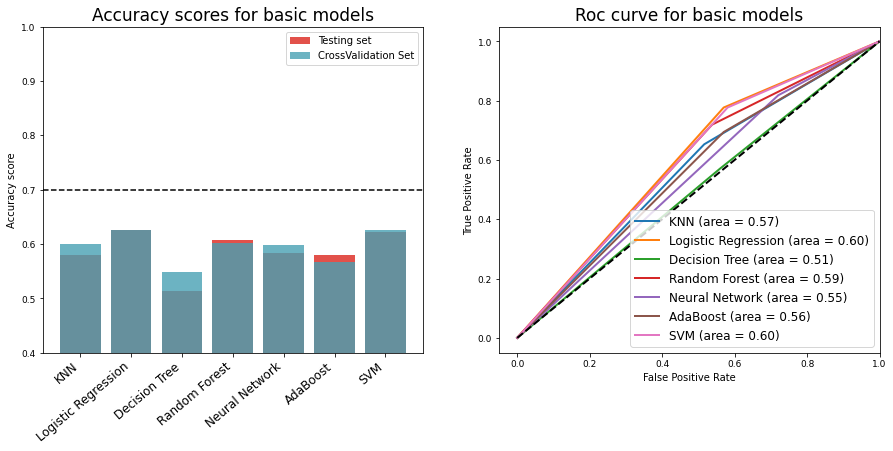

In [85]:
grafico_riassuntivo(knn_train, lg_train, dt_train, rf_train, rn_train, ad_train, svc_train, knn_test, lg_test, dt_test, rf_test, rn_test, ad_test, svc_test, knn_pred, lg_pred, dt_pred, rf_pred, rn_pred, ad_pred, svc_pred)

C) Mutazione dei geni


            Unique Mutations
patient_id               854
tp53_mut                 203
muc16_mut                145
ahnak2_mut               119
syne1_mut                 93
kmt2c_mut                 89
pik3ca_mut                84
dnah11_mut                81
map3k1_mut                71
cdh1_mut                  69


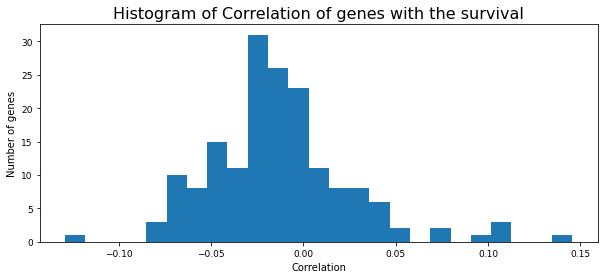

In [95]:
#Per avere solo le colonne che riguardano le mutazioni
#Drop columns that are not related to mutations
mutation_df_to_drop = df.columns[1:520]
mutation_df = df.drop(mutation_df_to_drop, axis = 1)

#Make a new dataframe with the unique counts of each mutation and sort
dfGroupedUniqueMutations = pd.DataFrame({"Unique Mutations": mutation_df.nunique()})
print(dfGroupedUniqueMutations.sort_values(by='Unique Mutations', ascending=False).head(10))


#Make dataframe of binary values for each gene (mutated = 1, not-mutated = 0)
mutation_df = mutation_df.applymap(lambda x: 1 if x != '0' else 0)
mutation_df.insert(loc=1 , column='overall_survival', value=df['overall_survival'])
mutation_df.head()

fig, ax = plt.subplots(figsize=(10,4))
corrs=[]
for col in mutation_df.drop(['patient_id'], axis = 1).columns:
    corr = mutation_df[[col,'overall_survival']].corr()['overall_survival'][col]
    corrs.append(corr)

corrs.pop(0)
ax.hist(corrs,  bins=25)
ax.set_xlabel("Correlation")
ax.set_ylabel("Number of genes")
ax.set_title("Histogram of Correlation of genes with the survival", size=16)


plt.show()

The genes with the most varied mutations were:

tp53
muc16
syne1
pik3ca
map3k1
ahnak2
kmt2c
gata3
cdh1
dnah11

DA CAPIRE
Nessuna correlazione tra sopravvivenza e mutazioni, poiché abbiamo cambiato la mutazione in 0 e 1 invece di 0 se non ci sono mutazioni e il tipo di mutazione se c'è una mutazione.

<AxesSubplot:>

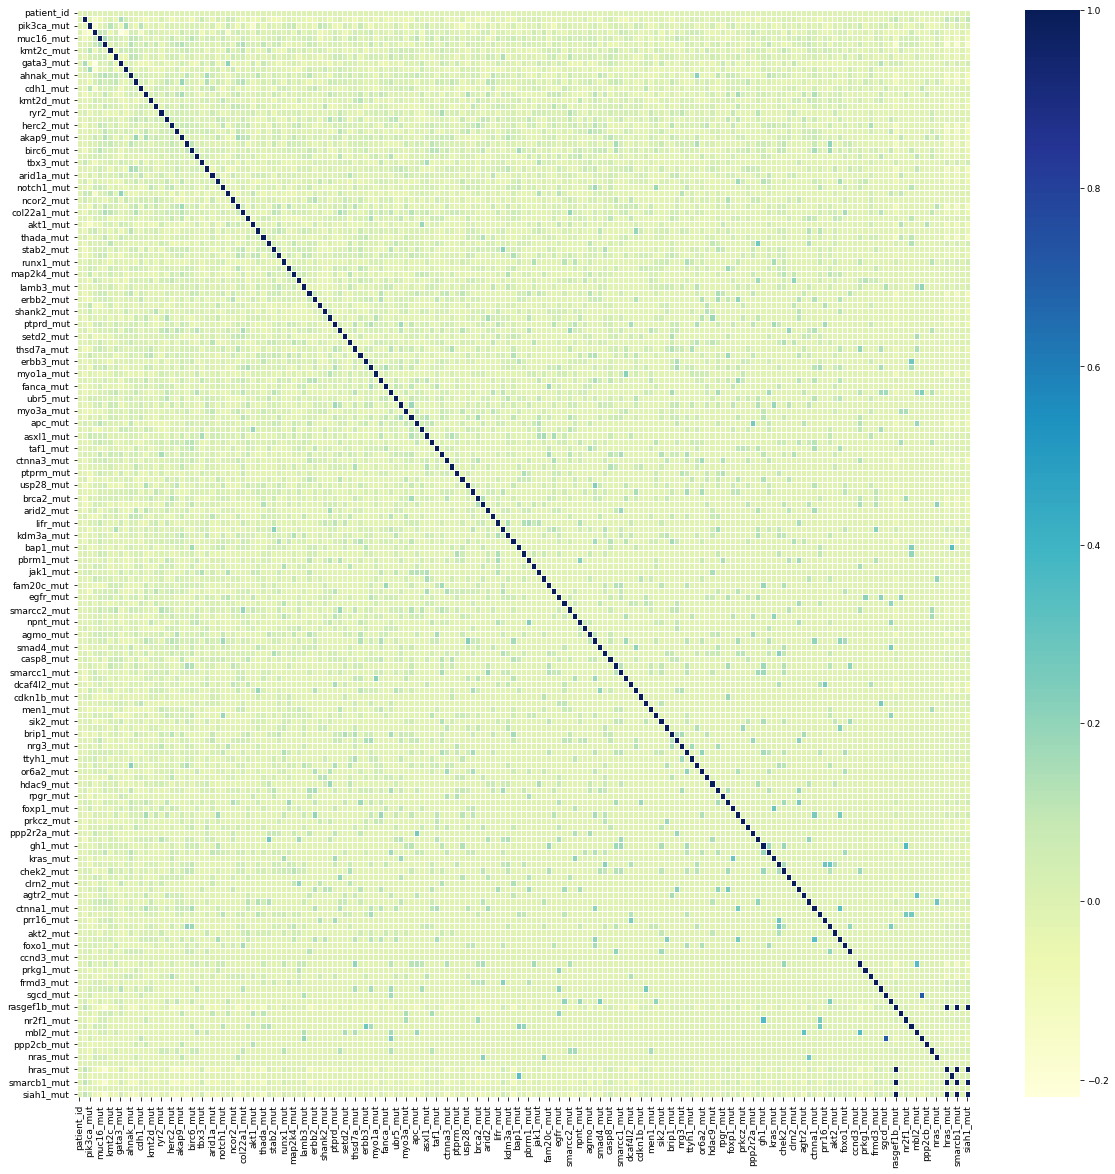

In [96]:
plt.figure(figsize=(20,20))
corr = mutation_df.corr().fillna(0)
sns.heatmap(corr, cmap = "YlGnBu", linewidths=0.5)

In [97]:
#The argsort returns indexes and columns from 0:len(columns),
#sorted in descending order by column values
#corr.values restituisce la rappresentazione della matrice di correlazione
#corr come un array NumPy.
#L'operazione -corr.values nega tutti i valori della matrice,
#invertendo l'ordine di ordinamento in modo che l'ordinamento venga
#eseguito in modo decrescente invece che crescente.
#np.argsort(-corr.values, axis=1) applica l'ordinamento decrescente alle
#colonne della matrice di correlazione corr e restituisce un array di indici
#che corrispondono all'ordine delle colonne in base alla loro correlazione decrescente.
#Gli indici nell'array arr corrispondono all'ordine delle colonne di corr in
#base alla loro correlazione decrescente. Ad esempio, arr[0] restituirà un
#array di indici che indica l'ordine delle colonne di corr in base alla
#correlazione più alta.
arr = np.argsort(-corr.values, axis=1)


#Il codice corr.apply(lambda row: row.nlargest(2).values[-1], axis=1)
#viene utilizzato per calcolare una nuova serie di dati chiamata corrValue
#che contiene il secondo valore più grande per ogni riga nella matrice di
#correlazione corr.
#Ecco una spiegazione passo-passo di come funziona il codice:
#corr è un DataFrame che rappresenta una matrice di correlazione tra le colonne di un dataset.
#corr.apply() viene utilizzato per applicare una funzione a ciascuna riga
#o colonna del DataFrame corr.
#lambda row: row.nlargest(2).values[-1] è una funzione lambda che prende
#in input una riga del DataFrame corr e restituisce il secondo valore più
#grande di quella riga.
#row.nlargest(2) seleziona i due valori più grandi nella riga.
#.values[-1] estrae l'ultimo valore tra i due valori più grandi,
#che rappresenta il secondo valore più grande.
#axis=1 specifica che la funzione lambda deve essere applicata lungo le righe del DataFrame corr.

corrValue = corr.apply(lambda row: row.nlargest(2).values[-1],axis=1)
#Qui creiamo un nuovo dataframe che ha come valori per ogni gene, il secondo
#gene con la correlazione maggiore (perchè il primo è se stesso) infatti se metto arr[:,0] ottengo lo stesso gene

dfUniqueMutationsBinary = pd.DataFrame({'Correlated Mutation': corr.columns[arr[:,1]], 'Pearson Correlation': corrValue}, index=corr.index)

bestMutation = dfUniqueMutationsBinary.sort_values(by = 'Pearson Correlation', ascending=False)
bestMutation.head(50)

Correlated Mutation  Pearson Correlation
siah1_mut            smarcb1_mut             1.000000
smarcb1_mut          smarcb1_mut             1.000000
hras_mut             smarcb1_mut             1.000000
rasgef1b_mut           siah1_mut             0.997377
sgcd_mut                mtap_mut             0.706692
mtap_mut                sgcd_mut             0.706692
nr2f1_mut                gh1_mut             0.351476
gh1_mut                nr2f1_mut             0.351476
nr3c1_mut               mbl2_mut             0.351476
mbl2_mut               nr3c1_mut             0.351476
bap1_mut               prps2_mut             0.331767
prps2_mut               bap1_mut             0.331767
ctnna1_mut              braf_mut             0.330983
braf_mut              ctnna1_mut             0.330983
agtr2_mut               mbl2_mut             0.313811
cdkn2a_mut              nras_mut             0.285959
nras_mut              cdkn2a_mut             0.285959
nf2_mut                prr16_mut             0.285959
prr16_mut                nf2_mut             0.285959
kras_mut               foxp1_mut             0.285959
foxp1_mut               kras_mut             0.285959
dtwd2_mut                nf2_mut             0.282881
erbb3_mut              klrg1_mut             0.278999
klrg1_mut              erbb3_mut             0.278999
ncor1_mut              prkce_mut             0.271201
prkce_mut              ncor1_mut             0.271201
gps2_mut               smad2_mut             0.264274
smad2_mut               gps2_mut             0.264274
magea8_mut             nr2f1_mut             0.264274
ppp2r2a_mut              apc_mut             0.261256
apc_mut              ppp2r2a_mut             0.261256
clk3_mut                braf_mut             0.254858
acvrl1_mut            large1_mut             0.254858
large1_mut            acvrl1_mut             0.254858
dcaf4l2_mut            prr16_mut             0.246762
smad4_mut             spaca1_mut             0.246762
spaca1_mut             smad4_mut             0.246762
adgra2_mut              mtap_mut             0.233342
ptpn22_mut              braf_mut             0.231957
npnt_mut               pbrm1_mut             0.230591
pbrm1_mut               npnt_mut             0.230591
zfp36l1_mut            usp28_mut             0.226071
usp28_mut            zfp36l1_mut             0.226071
sik1_mut                 nf2_mut             0.218547
sbno1_mut              stab2_mut             0.217040
stab2_mut              sbno1_mut             0.217040
palld_mut              myo1a_mut             0.216181
myo1a_mut              palld_mut             0.216181
frmd3_mut              sbno1_mut             0.215791
ahnak_mut              taf4b_mut             0.214526

Provo a fare i test

In [98]:
columns_to_drop = ['overall_survival', 'hras_mut','rasgef1b_mut', 'smarcb1_mut']
X = mutation_df.drop(columns_to_drop, axis = 1)
y = mutation_df['overall_survival']

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y)

In [99]:
#LOGISTIC REGRESSION
print("LOGISTIC REGRESSION")
logistic_regression = LogisticRegression(random_state=42, max_iter=2000)
#LogisticRegression(random_state=42):
lg_pred, lg_test, lg_train = metrics(logistic_regression, X_train, X_test, y_train, y_test, 4)

#DECISION TREE
print("DECISION TREE")
dec_tree_clf = tree.DecisionTreeClassifier()
dt_pred, dt_test, dt_train = metrics(dec_tree_clf, X_train, X_test, y_train, y_test, 4)

#RETE NEURALE
print("NEURAL NETWORK")
params = {
    'solver': ['lbfgs', 'sgd', 'adam'],
    'activation': ['logistic', 'tanh', 'relu']
}
MLP_clf = GridSearchCV(MLPClassifier(alpha=1e-5, hidden_layer_sizes=(10, 7, 2), max_iter = 10000, random_state=42), params, n_jobs=-1, cv=5)
rn_pred, rn_test, rn_train = metrics(MLP_clf, X_train, X_test, y_train, y_test, 4)

#KNN
print("KNN")
params = {
    "n_neighbors" : [5,15,25,30,35,40, 100],
    "weights" : ["uniform" , "distance"]
    }
    #Under some circumstances, it is better to weight the neighbors such that nearer neighbors
    #contribute more to the fit. This can be accomplished through the weights
    #keyword. The default value, weights = 'uniform', assigns uniform
    #weights to each neighbor. weights = 'distance' assigns weights proportional
    #to the inverse of the distance from the query point.

clf_neighbors = GridSearchCV(neighbors.KNeighborsClassifier(), params, n_jobs = -1, cv = 4)
knn_pred, knn_test, knn_train = metrics(clf_neighbors, X_train, X_test, y_train, y_test, 4)

#Random forest
print("RANDOM FOREST")
cl_random_forest = RandomForestClassifier(random_state=42)
rf_pred, rf_test, rf_train = metrics(cl_random_forest, X_train, X_test, y_train, y_test, 4)

#Adaboost
print("ADABOOST")
ada_boost = AdaBoostClassifier(random_state=42)
ad_pred, ad_test, ad_train = metrics(ada_boost, X_train, X_test, y_train, y_test, 4)

#SVM
print("SVM")
clf_linearsvc = svm.LinearSVC()
svc_pred, svc_test, svc_train = metrics(clf_linearsvc, X_train, X_test, y_train, y_test, 4)

LOGISTIC REGRESSION
CV scores:  [0.5875  0.625   0.55625 0.5625 ]
CV Standard Deviation:  0.02701815072779778
CV Mean score:  0.5828125

Train score:  0.7578125
Test score/Accuratezza del modello:  0.4392523364485981

Precision: 0.5037037037037037
Recall: 0.5619834710743802
Matrice di confusione :
[[26 67]
 [53 68]]

DECISION TREE
CV scores:  [0.55    0.58125 0.6     0.5625 ]
CV Standard Deviation:  0.01894430570778458
CV Mean score:  0.5734375

Train score:  0.9890625
Test score/Accuratezza del modello:  0.5607476635514018

Precision: 0.608
Recall: 0.628099173553719
Matrice di confusione :
[[44 49]
 [45 76]]

NEURAL NETWORK
CV scores:  [0.56875 0.59375 0.58125 0.5625 ]
CV Standard Deviation:  0.012001790231044708
CV Mean score:  0.5765625000000001

Train score:  0.9359375
Test score/Accuratezza del modello:  0.514018691588785

Precision: 0.5913978494623656
Recall: 0.45454545454545453
Matrice di confusione :
[[55 38]
 [66 55]]

KNN
CV scores:  [0.6375  0.59375 0.56875 0.5875 ]
CV Stand

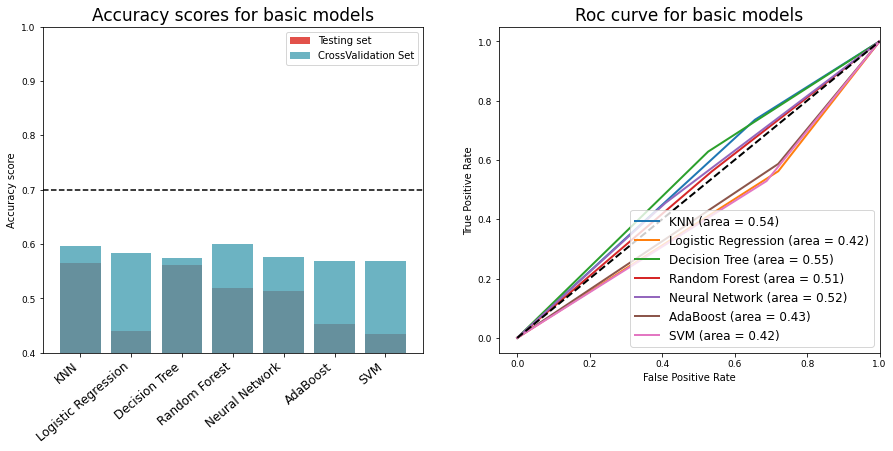

In [100]:
grafico_riassuntivo(knn_train, lg_train, dt_train, rf_train, rn_train, ad_train, svc_train, knn_test, lg_test, dt_test, rf_test, rn_test, ad_test, svc_test, knn_pred, lg_pred, dt_pred, rf_pred, rn_pred, ad_pred, svc_pred)

Classificazione con solo attributi clinici e genetici

In [86]:
features_to_drop = df.columns[520:]
df_all = df.drop(features_to_drop, axis = 1)
df_all = df_all.drop("death_from_cancer", axis = 1)
#df_all = df_all.drop("overall_survival_months", axis = 1)
all_categorical_columns = df_all.select_dtypes(include=['object']).columns.tolist()
dummies_df = pd.get_dummies(df_all.drop('patient_id',axis=1 ), columns= all_categorical_columns, dummy_na=False)
dummies_df.dropna(inplace = True)
dummies_df


age_at_diagnosis  chemotherapy  cohort  neoplasm_histologic_grade  \
1                43.19             0     1.0                        3.0   
2                48.87             1     1.0                        2.0   
3                47.68             1     1.0                        2.0   
4                76.97             1     1.0                        3.0   
5                78.77             0     1.0                        3.0   
...                ...           ...     ...                        ...   
1616             75.33             0     5.0                        1.0   
1619             70.65             0     5.0                        1.0   
1623             52.84             1     5.0                        2.0   
1628             48.59             1     5.0                        3.0   
1664             63.20             0     5.0                        2.0   

      hormone_therapy  lymph_nodes_examined_positive  mutation_count  \
1                   1                            0.0             2.0   
2                   1                            1.0             2.0   
3                   1                            3.0             1.0   
4                   1                            8.0             2.0   
5                   1                            0.0             4.0   
...               ...                            ...             ...   
1616                0                            0.0             5.0   
1619                0                            0.0             9.0   
1623                0                            6.0             5.0   
1628                0                            1.0             6.0   
1664                0                            0.0             3.0   

      nottingham_prognostic_index  overall_survival_months  overall_survival  \
1                           4.020                84.633333                 1   
2                           4.030               163.700000                 0   
3                           4.050               164.933333                 1   
4                           6.080                41.366667                 0   
5                           4.062                 7.800000                 0   
...                           ...                      ...               ...   
1616                        2.030                 0.100000                 0   
1619                        2.040               201.166667                 1   
1623                        5.040               200.333333                 1   
1628                        5.060                14.700000                 0   
1664                        3.044               281.500000                 1   

      ...  oncotree_code_IDC  oncotree_code_ILC  oncotree_code_IMMC  \
1     ...                  1                  0                   0   
2     ...                  1                  0                   0   
3     ...                  0                  0                   0   
4     ...                  0                  0                   0   
5     ...                  1                  0                   0   
...   ...                ...                ...                 ...   
1616  ...                  1                  0                   0   
1619  ...                  0                  0                   0   
1623  ...                  0                  0                   0   
1628  ...                  1                  0                   0   
1664  ...                  0                  0                   1   

      oncotree_code_MDLC  pr_status_Negative  pr_status_Positive  \
1                      0                   0                   1   
2                      0                   0                   1   
3                      1                   0                   1   
4                      1                   0                   1   
5                      0                   0                   1   
...               

In [87]:
# data splitting
X = dummies_df.drop( ['overall_survival'], axis=1)
y = dummies_df['overall_survival']

X_train, X_test, y_train, y_test = train_test_split(to_standard(X), y, random_state=42, stratify = y)

In [88]:
#LOGISTIC REGRESSION
print("LOGISIC REGRESSION")
logistic_regression = LogisticRegression(random_state=42, max_iter=1000)
lg_pred, lg_test, lg_train = metrics(logistic_regression, X_train, X_test, y_train, y_test, 4)

#DECISION TREE
print("DECISION TREE")
dec_tree_clf = tree.DecisionTreeClassifier()
dt_pred, dt_test, dt_train = metrics(dec_tree_clf, X_train, X_test, y_train, y_test, 4)

#RETE NEURALE
params = {
    'solver': ['lbfgs', 'sgd', 'adam'],
    'activation': ['logistic', 'tanh', 'relu']
}
print("NEURAL NETWORK")
MLP_clf = GridSearchCV(MLPClassifier(alpha=1e-5, hidden_layer_sizes=(10, 7, 2), max_iter = 2000, random_state=42), params, n_jobs=-1, cv=5)
rn_pred, rn_test, rn_train = metrics(MLP_clf, X_train, X_test, y_train, y_test, 4)

#KNN
params = {
    "n_neighbors" : [5,15,25,30,35,40, 100],
    "weights" : ["uniform" , "distance"]
    }
    #Under some circumstances, it is better to weight the neighbors such that nearer neighbors
    #contribute more to the fit. This can be accomplished through the weights
    #keyword. The default value, weights = 'uniform', assigns uniform
    #weights to each neighbor. weights = 'distance' assigns weights proportional
    #to the inverse of the distance from the query point.
print("KNN")
clf_neighbors = GridSearchCV(neighbors.KNeighborsClassifier(), params, n_jobs = -1, cv = 4)
knn_pred, knn_test, knn_train = metrics(clf_neighbors, X_train, X_test, y_train, y_test, 4)

#Random forest
print("RANDOM FOREST")
cl_random_forest = RandomForestClassifier(random_state=42)
rf_pred, rf_test, rf_train = metrics(cl_random_forest, X_train, X_test, y_train, y_test, 4)

#Adaboost
print("ADABOOST")
ada_boost = AdaBoostClassifier(random_state=42)
ad_pred, ad_test, ad_train = metrics(ada_boost, X_train, X_test, y_train, y_test, 4)

#SVM
print("SVM")
clf_linearsvc = svm.LinearSVC()
svc_pred, svc_test, svc_train = metrics(clf_linearsvc, X_train, X_test, y_train, y_test, 4)

LOGISIC REGRESSION
CV scores:  [0.65625    0.671875   0.625      0.68253968]
CV Standard Deviation:  0.02169917434845873

CV Mean score:  0.6589161706349207
Train score:  1.0
Test score:  0.7137254901960784

Accuratezza del modello:  0.7137254901960784
Precision: 0.7412587412587412
Recall: 0.7464788732394366
Matrice di confusione :
[[ 76  37]
 [ 36 106]]

DECISION TREE
CV scores:  [0.703125   0.625      0.640625   0.52380952]
CV Standard Deviation:  0.06436872017946695

CV Mean score:  0.6231398809523809
Train score:  1.0
Test score:  0.6784313725490196

Accuratezza del modello:  0.6784313725490196
Precision: 0.717391304347826
Recall: 0.6971830985915493
Matrice di confusione :
[[74 39]
 [43 99]]

NEURAL NETWORK
CV scores:  [0.640625   0.671875   0.6875     0.74603175]
CV Standard Deviation:  0.038286534132889585

CV Mean score:  0.6865079365079365
Train score:  0.9816272965879265
Test score:  0.6862745098039216

Accuratezza del modello:  0.6862745098039216
Precision: 0.75
Recall: 0.654

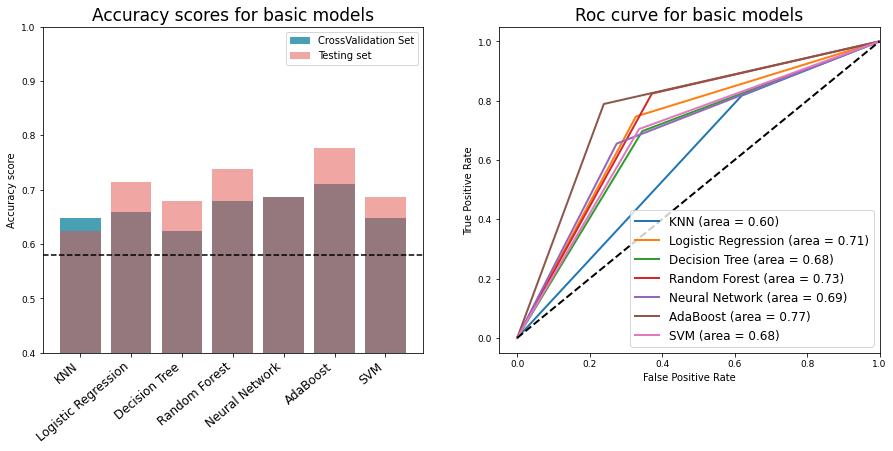

In [89]:
grafico_riassuntivo(knn_train, lg_train, dt_train, rf_train, rn_train, ad_train, svc_train, knn_test, lg_test, dt_test, rf_test, rn_test, ad_test, svc_test, knn_pred, lg_pred, dt_pred, rf_pred, rn_pred, ad_pred, svc_pred)

regressor = LogisticRegression(): Viene creato un oggetto LogisticRegression, che rappresenta il modello di regressione logistica. Questo sarà il modello che verrà utilizzato per valutare l'importanza delle feature durante il processo di eliminazione ricorsiva delle feature.

feature_selector = RFECV(regressor): Viene creato un oggetto RFECV (Recursive Feature Elimination with Cross-Validation) utilizzando il modello regressor come stimatore. RFECV è una tecnica che esegue la feature selection eliminando iterativamente le feature meno informative e utilizzando la validazione incrociata per valutare l'impatto delle feature rimosse sulle prestazioni del modello.

fit = feature_selector.fit(X, y): Il modello RFECV viene adattato (fit) ai dati X (le feature) e y (il target o l'etichetta). Durante questo processo, RFECV eseguirà la selezione delle feature in modo iterativo.

optimal_feature_count = feature_selector.n_features_: Dopo aver adattato RFECV ai dati, è possibile ottenere il numero ottimale di feature selezionate utilizzando il modello. Questo valore rappresenta il numero di feature che RFECV ha selezionato come le più informative durante il processo di eliminazione ricorsiva.

X_new = X.loc[:, feature_selector.get_support()]: Alla fine del processo, X_new conterrà solo le feature selezionate da RFECV come le più informative. feature_selector.get_support() restituirà un array di booleani che indica quali feature sono state selezionate. X.loc[:, feature_selector.get_support()] selezionerà solo le colonne corrispondenti alle feature selezionate nel DataFrame X.

print(X_new.columns): Questo comando stampa i nomi delle colonne del DataFrame X_new, che rappresentano le feature selezionate dopo il processo di feature selection.

In breve, il codice utilizza RFECV con un modello di regressione logistica per identificare le feature più informative e restituisce un DataFrame X_new contenente solo queste feature selezionate.

In [90]:
regressor = LogisticRegression(max_iter = 1000)
#ada_boost = AdaBoostClassifier(random_state=42)
feature_selector = RFECV(regressor)

fit = feature_selector.fit(X_train,y_train)

optimal_feature_count = feature_selector.n_features_
print(f"Optimal numer of features: {optimal_feature_count}")

X_new = X_train.loc[:, feature_selector.get_support()]
print(X_new.columns)



Optimal numer of features: 3
Index(['cohort', 'overall_survival_months', 'arid1a'], dtype='object')


In [91]:
X.columns.size

563

In [92]:
#Siccome X_train è stato modificato in X_train, ora modifichiamo anche X_test

#selected_columns = [X_new.columns]

# Usa il metodo loc per selezionare solo le colonne desiderate in X_test
X_test_new = X_test[X_new.columns]

In [97]:
#TEST DOPO AVER APPLICATO RFECV

#LOGISTIC REGRESSION
print("LOGISTIC REGRESSION")
params = {
    "penalty": ["l1"],
    "C": np.logspace(-2,4,100),
    "solver" : ["saga"]
    }
    #C": rappresenta l'inverso del parametro di regolarizzazione, che controlla l'intensità della regolarizzazione.
    #Vengono testati 100 valori equispaziati sulla scala logaritmica da 10^(-2) a 10^4.

logistic_regression = GridSearchCV(LogisticRegression(random_state=42, max_iter=4000), params, n_jobs=-1, cv=4)

lg_pred, lg_test, lg_train = metrics(logistic_regression, X_new, X_test_new, y_train, y_test, 4)

#DECISION TREE
print("DECISION TREE")
dec_tree_clf = tree.DecisionTreeClassifier()
dt_pred, dt_test, dt_train = metrics(dec_tree_clf, X_new, X_test_new, y_train, y_test, 4)

#RETE NEURALE
print("RETE NEURALE")
params = {
    'solver': ['sgd', 'adam'],
    'activation': ['logistic', 'tanh', 'relu']
}
MLP_clf = GridSearchCV(MLPClassifier(alpha=1e-5, hidden_layer_sizes=(10, 7, 2), max_iter = 20000, random_state=42), params, n_jobs=-1, cv=5)
rn_pred, rn_test, rn_train = metrics(MLP_clf, X_new, X_test_new, y_train, y_test, 4)

#KNN
print("KNN")
params = {
    "n_neighbors" : [5,15,25,30,35,40, 100],
    "weights" : ["uniform" , "distance"]
    }
    #Under some circumstances, it is better to weight the neighbors such that nearer neighbors
    #contribute more to the fit. This can be accomplished through the weights
    #keyword. The default value, weights = 'uniform', assigns uniform
    #weights to each neighbor. weights = 'distance' assigns weights proportional
    #to the inverse of the distance from the query point.

clf_neighbors = GridSearchCV(neighbors.KNeighborsClassifier(), params, n_jobs = -1, cv = 4)
knn_pred, knn_test, knn_train = metrics(clf_neighbors, X_new, X_test_new, y_train, y_test, 4)

#Random forest
print("RANDOM FOREST")
cl_random_forest = RandomForestClassifier(random_state=42)
rf_pred, rf_test, rf_train = metrics(cl_random_forest, X_new, X_test_new, y_train, y_test, 4)

#Adaboost
print("ADABOOST")
ada_boost = AdaBoostClassifier(random_state=42)
ad_pred, ad_test, ad_train = metrics(ada_boost, X_new, X_test_new, y_train, y_test, 4)

#SVM
print("SVM")
clf_linearsvc = svm.LinearSVC(max_iter=4000)
svc_pred, svc_test, svc_train = metrics(clf_linearsvc, X_new, X_test_new, y_train, y_test, 4)


LOGISTIC REGRESSION
CV scores:  [0.84375    0.8125     0.78125    0.79365079]
CV Standard Deviation:  0.023556285971032348

CV Mean score:  0.8077876984126984
Train score:  0.7979002624671916
Test score:  0.8156862745098039

Accuratezza del modello:  0.8156862745098039
Precision: 0.8518518518518519
Recall: 0.8098591549295775
Matrice di confusione :
[[ 93  20]
 [ 27 115]]

DECISION TREE
CV scores:  [0.765625   0.671875   0.6875     0.76190476]
CV Standard Deviation:  0.04242050325625103

CV Mean score:  0.7217261904761905
Train score:  1.0
Test score:  0.7333333333333333

Accuratezza del modello:  0.7333333333333333
Precision: 0.7803030303030303
Recall: 0.7253521126760564
Matrice di confusione :
[[ 84  29]
 [ 39 103]]

RETE NEURALE
CV scores:  [0.859375   0.78125    0.796875   0.82539683]
CV Standard Deviation:  0.02976035462232914

CV Mean score:  0.8157242063492063
Train score:  0.8057742782152231
Test score:  0.8274509803921568

Accuratezza del modello:  0.8274509803921568
Precision:

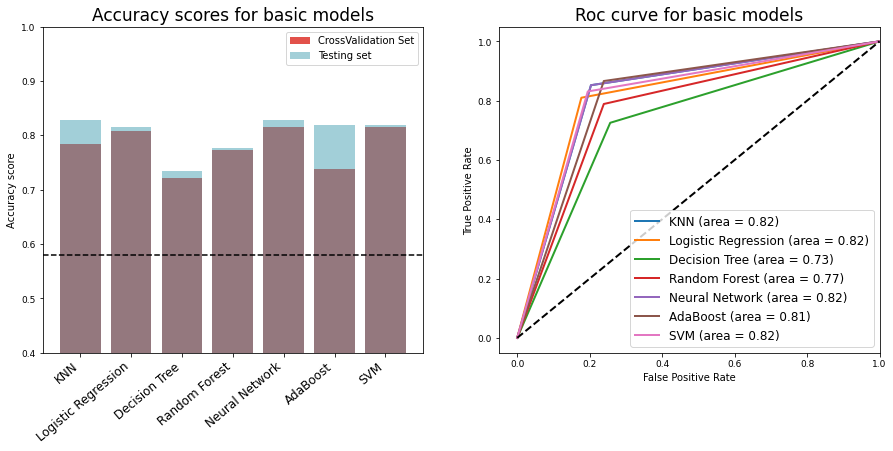

In [100]:
grafico_riassuntivo(knn_train, lg_train, dt_train, rf_train, rn_train, ad_train, svc_train, knn_test, lg_test, dt_test, rf_test, rn_test, ad_test, svc_test, knn_pred, lg_pred, dt_pred, rf_pred, rn_pred, ad_pred, svc_pred)

La PCA è una tecnica di riduzione delle dimensioni dei dati che mira a semplificare un dataset mantenendo le informazioni più importanti e significative. Ecco come funziona in modo più dettagliato:

Identificazione delle componenti principali (Principal Components):

La PCA inizia identificando le "componenti principali" nei dati. Queste componenti sono delle combinazioni lineari delle feature originali che catturano la massima varianza nei dati.
La prima componente principale rappresenta la direzione lungo la quale i dati variano di più. È progettata in modo da catturare la massima varianza nei dati.
Le successive componenti principali vengono selezionate in modo che siano ortogonali (indipendenti) rispetto alle componenti precedenti e catturino la varianza residua nei dati.
Riduzione della dimensionalità:

Una volta identificate le componenti principali, è possibile selezionare un numero inferiore di queste componenti per rappresentare i dati in modo più compatto. Questa scelta dipende dall'obiettivo dell'analisi.
Ad esempio, se hai un dataset iniziale con molte feature (ad esempio, 100) ma scopri che le prime due o tre componenti principali catturano la maggior parte della varianza nei dati, puoi scegliere di utilizzare solo queste due o tre componenti per rappresentare il dataset.
Riduzione del rumore e semplificazione:

La PCA aiuta a ridurre il rumore nei dati. Rimuovendo le componenti con varianza bassa, è possibile eliminare il rumore o le informazioni irrilevanti, migliorando così la qualità delle analisi e dei modelli successivi.
Inoltre, la PCA semplifica i dati, consentendo una comprensione più chiara delle relazioni tra le feature e semplificando le visualizzazioni.
La PCA è ampiamente utilizzata in molte applicazioni, tra cui analisi dei dati, riduzione del rumore, compressione dei dati, visualizzazione dei dati, riconoscimento dei pattern e molto altro. È una tecnica potente per esplorare, semplificare e analizzare dataset complessi.

Un aspetto importante della PCA è la capacità di scegliere il numero di componenti principali da utilizzare in base agli obiettivi specifici. Questa scelta può essere basata sulla varianza spiegata (quanta varianza viene catturata da ciascuna componente principale) o su criteri specifici del problema.






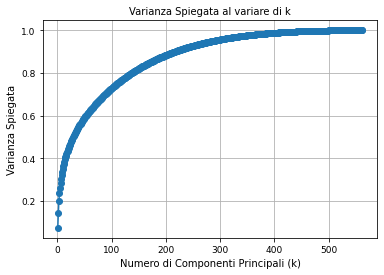

In [101]:
from sklearn.decomposition import PCA

# Range di valori di k (numero di componenti principali)
k_values = range(1, len(X.columns))  # Esempio: da 5 a 580 componenti principali

# Esegui PCA con diversi valori di k
explained_variances = []
for k in k_values:
    pca = PCA(n_components=k)
    X_pca = pca.fit_transform(X_train, y_train)
    explained_variances.append(np.sum(pca.explained_variance_ratio_))

# Visualizza la varianza spiegata al variare di k
plt.plot(k_values, explained_variances, marker='o')
plt.xlabel('Numero di Componenti Principali (k)')
plt.ylabel('Varianza Spiegata')
plt.title('Varianza Spiegata al variare di k')
plt.grid(True)
plt.show()


Osserva il grafico della varianza spiegata in funzione di k. Cerca il punto in cui la varianza spiegata smette di crescere in modo significativo e inizia a livellarsi. Questo è un suggerimento per selezionare k.
In questo caso posso usare 400 per esempio

In [102]:
pca = PCA(n_components=370)
X_pca = pca.fit_transform(X_train, y_train)
X_test_new = pca.transform(X_test)

#X_train, X_test, y_train, y_test = train_test_split(X_pca, y, random_state=42, stratify = y)


In [103]:
X_pca.shape[:]

(762, 370)

In [108]:
#TEST DOPO AVER APPLICATO PCA
print("LOGISTIC REGRESSION")
#LOGISTIC REGRESSION
logistic_regression = LogisticRegression(random_state=42, max_iter=4000)
lg_pred, lg_test, lg_train = metrics(logistic_regression, X_pca, X_test_new, y_train, y_test, 4)

#DECISION TREE
print("DECISION TREE")

dec_tree_clf = tree.DecisionTreeClassifier()
dt_pred, dt_test, dt_train = metrics(dec_tree_clf, X_pca, X_test_new, y_train, y_test, 4)

#RETE NEURALE
print("NEURAL NETWORK")
params = {
    'solver': ['sgd', 'adam'],
    'activation': ['logistic', 'tanh', 'relu']
}
MLP_clf = GridSearchCV(MLPClassifier(alpha=1e-5, hidden_layer_sizes=(10, 7, 2), max_iter = 50000, random_state=42), params, n_jobs=-1, cv=5)
rn_pred, rn_test, rn_train = metrics(MLP_clf, X_pca, X_test_new, y_train, y_test, 4)

#KNN
print("KNN")
params = {
    "n_neighbors" : [5,15,25,30,35,40, 100],
    "weights" : ["uniform" , "distance"]
    }
    #Under some circumstances, it is better to weight the neighbors such that nearer neighbors
    #contribute more to the fit. This can be accomplished through the weights
    #keyword. The default value, weights = 'uniform', assigns uniform
    #weights to each neighbor. weights = 'distance' assigns weights proportional
    #to the inverse of the distance from the query point.

clf_neighbors = GridSearchCV(neighbors.KNeighborsClassifier(), params, n_jobs = -1, cv = 4)
knn_pred, knn_test, knn_train = metrics(clf_neighbors, X_pca, X_test_new, y_train, y_test, 4)

#Random forest
print("RANDOM FOREST")
cl_random_forest = RandomForestClassifier(random_state=42)
rf_pred, rf_test, rf_train = metrics(cl_random_forest, X_pca, X_test_new, y_train, y_test, 4)

#Adaboost
print("ADABOOST")
ada_boost = AdaBoostClassifier(random_state=42)
ad_pred, ad_test, ad_train = metrics(ada_boost, X_pca, X_test_new, y_train, y_test, 4)

#SVM
print("SVM")
clf_linearsvc = svm.LinearSVC(max_iter=4000)
svc_pred, svc_test, svc_train = metrics(clf_linearsvc, X_pca, X_test_new, y_train, y_test, 4)


LOGISTIC REGRESSION
CV scores:  [0.625      0.671875   0.640625   0.71428571]
CV Standard Deviation:  0.034108720513250285

CV Mean score:  0.6629464285714286
Train score:  1.0
Test score:  0.7333333333333333

Accuratezza del modello:  0.7333333333333333
Precision: 0.7534246575342466
Recall: 0.7746478873239436
Matrice di confusione :
[[ 77  36]
 [ 32 110]]

DECISION TREE
CV scores:  [0.46875    0.53125    0.5        0.52380952]
CV Standard Deviation:  0.02438388334549694

CV Mean score:  0.5059523809523809
Train score:  1.0
Test score:  0.6470588235294118

Accuratezza del modello:  0.6470588235294118
Precision: 0.6805555555555556
Recall: 0.6901408450704225
Matrice di confusione :
[[67 46]
 [44 98]]

NEURAL NETWORK
CV scores:  [0.625      0.640625   0.671875   0.71428571]
CV Standard Deviation:  0.034108720513250285

CV Mean score:  0.6629464285714286
Train score:  0.973753280839895
Test score:  0.6823529411764706

Accuratezza del modello:  0.6823529411764706
Precision: 0.75206611570247

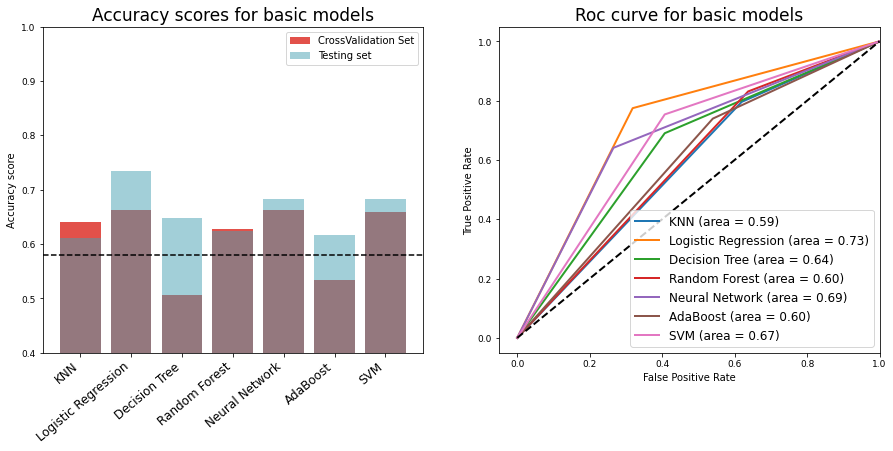

In [109]:
grafico_riassuntivo(knn_train, lg_train, dt_train, rf_train, rn_train, ad_train, svc_train, knn_test, lg_test, dt_test, rf_test, rn_test, ad_test, svc_test, knn_pred, lg_pred, dt_pred, rf_pred, rn_pred, ad_pred, svc_pred)

/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [503 504] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [503 504] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: 

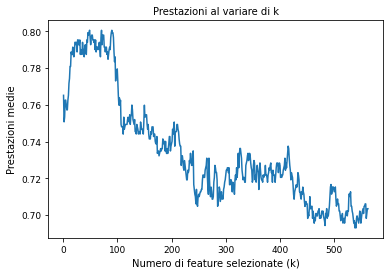

Best k:  49


In [111]:
#Selezione basata su statistiche:
#Utilizzare test statistici come l'ANOVA (Analysis of Variance) o il test chi-quadrato per valutare la rilevanza delle feature rispetto al target.
#Scikit-learn fornisce la classe SelectKBest per selezionare le prime K feature basate su un test di significatività.
#score_func=f_classif è un parametro utilizzato nella classe SelectKBest di scikit-learn per specificare quale funzione
#di scoring o test statistico deve essere utilizzata per valutare la rilevanza delle feature nel contesto di una
#classificazione (classification task). In questo caso, f_classif è una delle opzioni disponibili per il calcolo
#del punteggio di rilevanza delle feature.

#f_classif rappresenta il test F di ANOVA (Analysis of Variance), che è utilizzato per valutare se ci sono
#differenze significative nelle medie dei valori delle feature tra le diverse classi o categorie di un problema di
#classificazione. Il punteggio restituito da f_classif misura quanto le feature siano informative per distinguere
#le diverse classi nel dataset.

k_values = range(1, len(X.columns))
scores = []

#Uso come classificatore:
#dec_tree_clf = tree.DecisionTreeClassifier()
clf = LogisticRegression(random_state=42, max_iter=4000)
best_K = 0
max = 0

for k in k_values:
    selector = SelectKBest(score_func=f_classif, k=k)
    pipeline = Pipeline([('selector', selector), ('classifier', clf)])
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)  # Esempio di 5-fold cross-validation
    scores.append(cv_scores.mean())
    if(cv_scores.mean() > max):
      max = cv_scores.mean()
      best_K = k

plt.plot(k_values, scores)
plt.xlabel('Numero di feature selezionate (k)')
plt.ylabel('Prestazioni medie')
plt.title('Prestazioni al variare di k')
plt.show()
print("Best k: ", best_K)


Come vedo dal grafico, intorno alle 49 feature ottengo i risultati migliori. Quindi scelgo k = 49

In [112]:
selector = SelectKBest(score_func=f_classif, k=best_K)
X_new = selector.fit_transform(X_train, y_train)
X_test_new = selector.transform(X_test)

#X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=42, stratify = y)

/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [503 504] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [115]:
#LOGISTIC REGRESSION
print("LOGISTIC REGRESSION")
logistic_regression = LogisticRegression(random_state=42, max_iter=4000)
lg_pred, lg_test, lg_train = metrics(logistic_regression, X_new, X_test_new, y_train, y_test, 4)

#DECISION TREE
print("DECISION TREE")
dec_tree_clf = tree.DecisionTreeClassifier()
dt_pred, dt_test, dt_train = metrics(dec_tree_clf, X_new, X_test_new, y_train, y_test, 4)

#RETE NEURALE
print("NEURAL NETWORK")
params = {
    'solver': ['lbfgs', 'sgd', 'adam'],
    'activation': ['logistic', 'tanh', 'relu']
}
MLP_clf = GridSearchCV(MLPClassifier(alpha=1e-5, hidden_layer_sizes=(10, 7, 2), max_iter = 10000, random_state=42), params, n_jobs=-1, cv=5)
rn_pred, rn_test, rn_train = metrics(MLP_clf, X_new, X_test_new, y_train, y_test, 4)

#KNN
print("KNN")
params = {
    "n_neighbors" : [5,15,25,30,35,40, 100],
    "weights" : ["uniform" , "distance"]
    }
    #Under some circumstances, it is better to weight the neighbors such that nearer neighbors
    #contribute more to the fit. This can be accomplished through the weights
    #keyword. The default value, weights = 'uniform', assigns uniform
    #weights to each neighbor. weights = 'distance' assigns weights proportional
    #to the inverse of the distance from the query point.

clf_neighbors = GridSearchCV(neighbors.KNeighborsClassifier(), params, n_jobs = -1, cv = 4)
knn_pred, knn_test, knn_train = metrics(clf_neighbors, X_new, X_test_new, y_train, y_test, 4)

#Random forest
print("RANDOM FOREST")
cl_random_forest = RandomForestClassifier(random_state=42)
rf_pred, rf_test, rf_train = metrics(cl_random_forest, X_new, X_test_new, y_train, y_test, 4)

#Adaboost
print("ADABOOST")
ada_boost = AdaBoostClassifier(random_state=42)
ad_pred, ad_test, ad_train = metrics(ada_boost, X_new, X_test_new, y_train, y_test, 4)

#SVM
print("SVM")
clf_linearsvc = svm.LinearSVC(max_iter = 10000)
svc_pred, svc_test, svc_train = metrics(clf_linearsvc, X_new, X_test_new, y_train, y_test, 4)

LOGISTIC REGRESSION
CV scores:  [0.734375   0.75       0.71875    0.77777778]
CV Standard Deviation:  0.021800986727212434

CV Mean score:  0.7452256944444444
Train score:  0.8359580052493438
Test score:  0.7725490196078432

Accuratezza del modello:  0.7725490196078432
Precision: 0.8181818181818182
Recall: 0.7605633802816901
Matrice di confusione :
[[ 89  24]
 [ 34 108]]

DECISION TREE
CV scores:  [0.609375   0.625      0.671875   0.76190476]
CV Standard Deviation:  0.05940394367040741

CV Mean score:  0.6670386904761905
Train score:  1.0
Test score:  0.7137254901960784

Accuratezza del modello:  0.7137254901960784
Precision: 0.7716535433070866
Recall: 0.6901408450704225
Matrice di confusione :
[[84 29]
 [44 98]]

NEURAL NETWORK
CV scores:  [0.734375   0.671875   0.703125   0.82539683]
CV Standard Deviation:  0.057371431184004396

CV Mean score:  0.7336929563492063
Train score:  0.9199475065616798
Test score:  0.7843137254901961

Accuratezza del modello:  0.7843137254901961
Precision: 

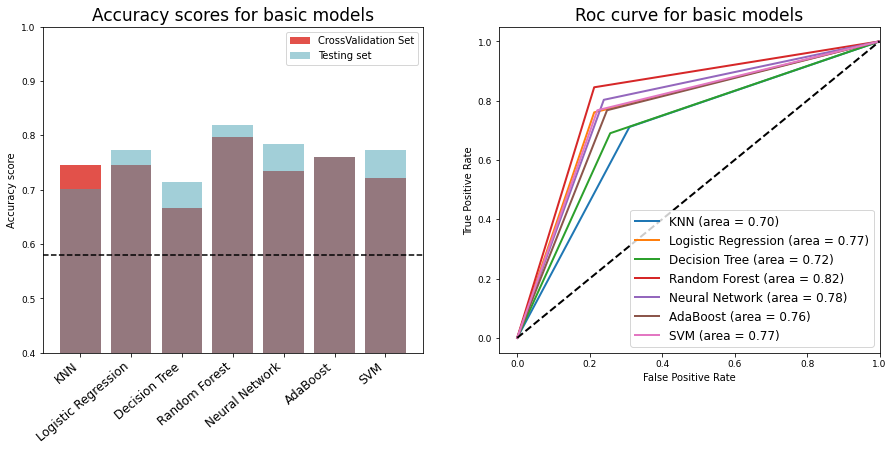

In [116]:
grafico_riassuntivo(knn_train, lg_train, dt_train, rf_train, rn_train, ad_train, svc_train, knn_test, lg_test, dt_test, rf_test, rn_test, ad_test, svc_test, knn_pred, lg_pred, dt_pred, rf_pred, rn_pred, ad_pred, svc_pred)

CI SONO STATI NETTI MIGLIORAMENTI


La scelta tra PCA (Principal Component Analysis), RFECV (Recursive Feature Elimination with Cross-Validation) e SelectKBest dipenderà dalle specifiche caratteristiche del tuo dataset, dagli obiettivi del tuo progetto e dalle prestazioni desiderate. Ecco alcune considerazioni per aiutarti a decidere quale criterio di feature selection utilizzare:

PCA (Principal Component Analysis):

Tipo di dati: PCA è adatto per dati numerici continui. Funziona bene quando le feature sono correlate o quando desideri ridurre drasticamente le dimensioni dei dati. Tuttavia, PCA non preserva necessariamente l'interpretabilità delle feature originali.

Obiettivi: Utilizza PCA quando l'obiettivo principale è la riduzione delle dimensioni o la decorrelazione delle feature. Ad esempio, se hai un dataset con molte feature altamente correlate e vuoi rappresentarlo in modo più compatto, PCA può essere utile.

Complessità interpretativa: PCA può rendere difficile interpretare quali feature originali contribuiscano alle componenti principali. Se l'interpretabilità è importante, potresti preferire altre tecniche di feature selection.

RFECV (Recursive Feature Elimination with Cross-Validation):

Tipo di dati: RFECV è adatto per dati numerici e problemi di classificazione o regressione con target noti. È particolarmente utile quando vuoi selezionare feature basate sulle loro prestazioni in un modello di machine learning specifico.

Obiettivi: Utilizza RFECV quando vuoi selezionare un sottoinsieme di feature che massimizza le prestazioni del tuo modello di machine learning. È efficace quando le prestazioni del modello sono cruciali e desideri mantenere l'interpretabilità delle feature.

Calcolo delle prestazioni: RFECV richiede l'addestramento ripetuto del modello su sottoinsiemi diversi di feature, il che può richiedere tempo. Assicurati di avere il tempo di calcolo necessario per eseguire RFECV.

SelectKBest:

Tipo di dati: SelectKBest è adatto per dati numerici e può essere utilizzato in problemi di classificazione o regressione. È una scelta solida quando desideri selezionare un numero fisso di feature basate su test statistici.

Obiettivi: Utilizza SelectKBest quando vuoi una feature selection basata su test statistici specifici come l'ANOVA o il chi-quadrato. Puoi controllare il numero esatto di feature da selezionare con il parametro k.

Controllo manuale: SelectKBest richiede la specifica del numero esatto di feature da selezionare. Devi decidere preventivamente quanti feature desideri mantenere.

In generale, la scelta tra queste tecniche dipenderà dalla natura del tuo problema, dalla tua familiarità con i dati, dalla disponibilità di risorse computazionali e dall'importanza dell'interpretabilità delle feature. Puoi anche eseguire confronti empirici per valutare quale tecnica funziona meglio per il tuo specifico caso d'uso. Spesso, una combinazione di queste tecniche può essere utilizzata in un flusso di lavoro di feature selection per ottenere i migliori risultati.

In [117]:
#INVECE CON TUTTO IL DATASET INSIEME
columns_to_drop = ['hras_mut','siah1_mut', 'smarcb1_mut', "death_from_cancer"]
all_df = df.drop(columns_to_drop, axis = 1)
all_df.iloc[:, 519:] = all_df.iloc[:, 519:].applymap(lambda x: 1 if x != '0' else 0)

columns_object = all_df.select_dtypes(include = ['object']).columns.to_list()
dataset = pd.get_dummies(all_df.drop('patient_id',axis=1 ), columns = columns_object, dummy_na = False)
dataset.dropna(inplace = True)

X = dataset.drop("overall_survival", axis = 1)
y = dataset['overall_survival']

X_train, X_test, y_train, y_test = train_test_split(to_standard(X), y, random_state=42, stratify = y)


In [118]:
regressor = LogisticRegression(max_iter = 1000)
feature_selector = RFECV(regressor)

fit = feature_selector.fit(X_train,y_train)

optimal_feature_count = feature_selector.n_features_
print(f"Optimal numer of features: {optimal_feature_count}")

X_new = X_train.loc[:, feature_selector.get_support()]
print(X_new.columns)

Optimal numer of features: 5
Index(['cohort', 'lymph_nodes_examined_positive', 'overall_survival_months',
       'ccnb1', 'mmp2'],
      dtype='object')


In [119]:
#Siccome X_train è stato modificato in X_train, ora modifichiamo anche X_test

# Usa il metodo loc per selezionare solo le colonne desiderate in X_test
X_test_new = X_test[X_new.columns]

In [120]:
X_new.shape[:]

(762, 5)

In [121]:
X_test_new.shape[:]

(255, 5)

In [125]:
#LOGISTIC REGRESSION (Senza GridSearchCV perchè ci impiega troppo tempo)
print("LOGISTIC REGRESSION ")
logistic_regression = LogisticRegression(random_state=42, max_iter=2000)
lg_pred, lg_test, lg_train = metrics(logistic_regression, X_new, X_test_new, y_train, y_test, 4)

#DECISION TREE
print("DECISION TREE")
dec_tree_clf = tree.DecisionTreeClassifier()
dt_pred, dt_test, dt_train = metrics(dec_tree_clf, X_new, X_test_new, y_train, y_test, 4)

#RETE NEURALE
print("NEURAL NETWORK")
params = {
    'solver': ['sgd', 'adam'],
    'activation': ['logistic', 'tanh', 'relu']
}
MLP_clf = GridSearchCV(MLPClassifier(alpha=1e-5, hidden_layer_sizes=(10, 7, 2), max_iter = 70000, random_state=42), params, n_jobs=-1, cv=5)
rn_pred, rn_test, rn_train = metrics(MLP_clf, X_new, X_test_new, y_train, y_test, 4)

#KNN
print("KNN")
params = {
    "n_neighbors" : [5,15,25,30,35,40, 100],
    "weights" : ["uniform" , "distance"]
    }
    #Under some circumstances, it is better to weight the neighbors such that nearer neighbors
    #contribute more to the fit. This can be accomplished through the weights
    #keyword. The default value, weights = 'uniform', assigns uniform
    #weights to each neighbor. weights = 'distance' assigns weights proportional
    #to the inverse of the distance from the query point.

clf_neighbors = GridSearchCV(neighbors.KNeighborsClassifier(), params, n_jobs = -1, cv = 4)
knn_pred, knn_test, knn_train = metrics(clf_neighbors, X_new, X_test_new, y_train, y_test, 4)

#Random forest
print("RANDOM FOREST")
cl_random_forest = RandomForestClassifier(random_state=42)
rf_pred, rf_test, rf_train = metrics(cl_random_forest, X_new, X_test_new, y_train, y_test, 4)

#Adaboost
print("ADABOOST")
ada_boost = AdaBoostClassifier(random_state=42)
ad_pred, ad_test, ad_train = metrics(ada_boost, X_new, X_test_new, y_train, y_test, 4)

#SVM
print("SVM")
clf_linearsvc = svm.LinearSVC(max_iter=10000)
svc_pred, svc_test, svc_train = metrics(clf_linearsvc, X_new, X_test_new, y_train, y_test, 4)


LOGISTIC REGRESSION 
CV scores:  [0.8125     0.8125     0.8125     0.85714286]
CV Standard Deviation:  0.019330924191616913

CV Mean score:  0.8236607142857143
Train score:  0.7939632545931758
Test score:  0.8235294117647058

Accuratezza del modello:  0.8235294117647058
Precision: 0.8592592592592593
Recall: 0.8169014084507042
Matrice di confusione :
[[ 94  19]
 [ 26 116]]

DECISION TREE
CV scores:  [0.828125   0.71875    0.671875   0.63492063]
CV Standard Deviation:  0.07258406031274578

CV Mean score:  0.7134176587301587
Train score:  1.0
Test score:  0.7529411764705882

Accuratezza del modello:  0.7529411764705882
Precision: 0.7801418439716312
Recall: 0.7746478873239436
Matrice di confusione :
[[ 82  31]
 [ 32 110]]

NEURAL NETWORK
CV scores:  [0.796875   0.84375    0.8125     0.84126984]
CV Standard Deviation:  0.019721063668374113

CV Mean score:  0.8235987103174603
Train score:  0.8359580052493438
Test score:  0.807843137254902

Accuratezza del modello:  0.807843137254902
Precisio

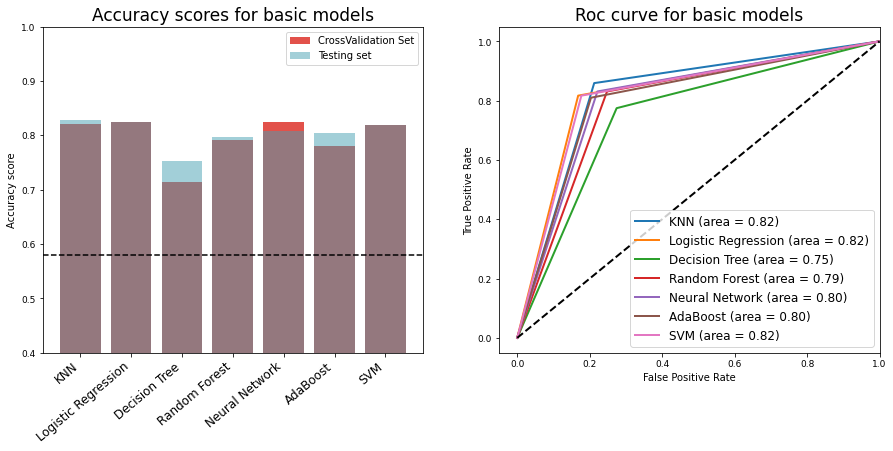

In [126]:
grafico_riassuntivo(knn_train, lg_train, dt_train, rf_train, rn_train, ad_train, svc_train, knn_test, lg_test, dt_test, rf_test, rn_test, ad_test, svc_test, knn_pred, lg_pred, dt_pred, rf_pred, rn_pred, ad_pred, svc_pred)

/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [670 673 674] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [670 673 674] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserW

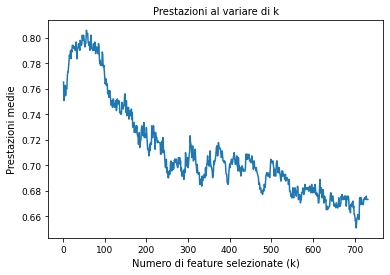

BEST K : 56


In [127]:

# Crea un grafico delle prestazioni per valori di k da 1 a al max num di features -1
k_values = range(1, len(X.columns))
scores = []

#Uso come classificatore:
#dec_tree_clf = tree.DecisionTreeClassifier()
clf = LogisticRegression(random_state=42, max_iter=4000)

max = 0
best_k = 0
for k in k_values:
    selector = SelectKBest(score_func=f_classif, k=k)
    pipeline = Pipeline([('selector', selector), ('classifier', clf)])
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)  # Esempio di 5-fold cross-validation
    scores.append(cv_scores.mean())
    if max < cv_scores.mean():
      max = cv_scores.mean()
      best_k = k

plt.plot(k_values, scores)
plt.xlabel('Numero di feature selezionate (k)')
plt.ylabel('Prestazioni medie')
plt.title('Prestazioni al variare di k')
plt.show()
print("BEST K :", best_k)


In [128]:
selector = SelectKBest(score_func=f_classif, k=best_k)
X_new = selector.fit_transform(X_train, y_train)
X_test_new = selector.transform(X_test)

#X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=42, stratify = y)

/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [670 673 674] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [129]:
#LOGISTIC REGRESSION (Senza GridSearchCV perchè ci impiega troppo tempo)
print("LOGISTIC REGRESSION")
logistic_regression = LogisticRegression(random_state=42, max_iter=2000)
lg_pred, lg_test, lg_train = metrics(logistic_regression, X_new, X_test_new, y_train, y_test, 4)

#DECISION TREE
print("DECISION TREE")
dec_tree_clf = tree.DecisionTreeClassifier()
dt_pred, dt_test, dt_train = metrics(dec_tree_clf, X_new, X_test_new, y_train, y_test, 4)

#RETE NEURALE
print("NEURAL NETWORK")
params = {
    'solver': ['lbfgs', 'sgd', 'adam'],
    'activation': ['logistic', 'tanh', 'relu']
}
MLP_clf = GridSearchCV(MLPClassifier(alpha=1e-5, hidden_layer_sizes=(10, 7, 2), max_iter = 20000, random_state=42), params, n_jobs=-1, cv=5)
rn_pred, rn_test, rn_train = metrics(MLP_clf, X_new, X_test_new, y_train, y_test, 4)

#KNN
print("KNN")
params = {
    "n_neighbors" : [5,15,25,30,35,40, 100],
    "weights" : ["uniform" , "distance"]
    }
    #Under some circumstances, it is better to weight the neighbors such that nearer neighbors
    #contribute more to the fit. This can be accomplished through the weights
    #keyword. The default value, weights = 'uniform', assigns uniform
    #weights to each neighbor. weights = 'distance' assigns weights proportional
    #to the inverse of the distance from the query point.

clf_neighbors = GridSearchCV(neighbors.KNeighborsClassifier(), params, n_jobs = -1, cv = 4)
knn_pred, knn_test, knn_train = metrics(clf_neighbors, X_new, X_test_new, y_train, y_test, 4)

#Random forest
print("RANDOM FOREST")
cl_random_forest = RandomForestClassifier(random_state=42)
rf_pred, rf_test, rf_train = metrics(cl_random_forest, X_new, X_test_new, y_train, y_test, 4)

#Adaboost
print("ADABOOST")
ada_boost = AdaBoostClassifier(random_state=42)
ad_pred, ad_test, ad_train = metrics(ada_boost, X_new, X_test_new, y_train, y_test, 4)

#SVM
print("SVM")
clf_linearsvc = svm.LinearSVC(max_iter=10000)
svc_pred, svc_test, svc_train = metrics(clf_linearsvc, X_new, X_test_new, y_train, y_test, 4)


LOGISTIC REGRESSION
CV scores:  [0.6875     0.75       0.75       0.76190476]
CV Standard Deviation:  0.029189055425495568

CV Mean score:  0.7373511904761905
Train score:  0.847769028871391
Test score:  0.7764705882352941

Accuratezza del modello:  0.7764705882352941
Precision: 0.8148148148148148
Recall: 0.7746478873239436
Matrice di confusione :
[[ 88  25]
 [ 32 110]]

DECISION TREE
CV scores:  [0.703125  0.625     0.671875  0.6984127]
CV Standard Deviation:  0.031017357299509357

CV Mean score:  0.6746031746031746
Train score:  1.0
Test score:  0.7215686274509804

Accuratezza del modello:  0.7215686274509804
Precision: 0.7709923664122137
Recall: 0.7112676056338029
Matrice di confusione :
[[ 83  30]
 [ 41 101]]

NEURAL NETWORK
CV scores:  [0.6875     0.734375   0.765625   0.79365079]
CV Standard Deviation:  0.0394052658008591

CV Mean score:  0.7452876984126984
Train score:  0.931758530183727
Test score:  0.7372549019607844

Accuratezza del modello:  0.7372549019607844
Precision: 0.7

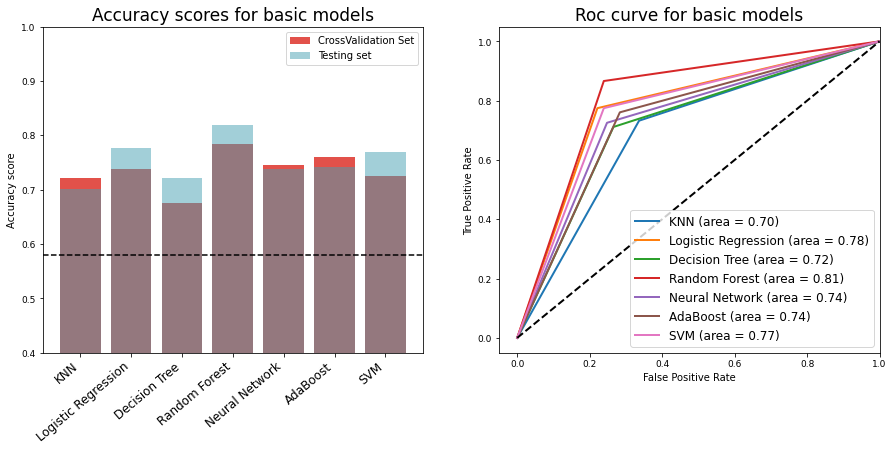

In [130]:
grafico_riassuntivo(knn_train, lg_train, dt_train, rf_train, rn_train, ad_train, svc_train, knn_test, lg_test, dt_test, rf_test, rn_test, ad_test, svc_test, knn_pred, lg_pred, dt_pred, rf_pred, rn_pred, ad_pred, svc_pred)

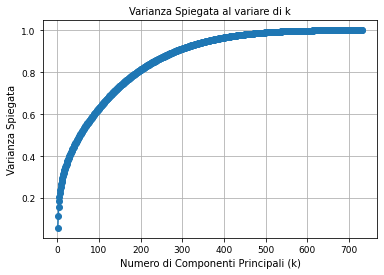

In [132]:
#CON PCA
# Range di valori di k (numero di componenti principali)
k_values = range(1, len(X_train.columns))  # Esempio: da 5 a 580 componenti principali

# Esegui PCA con diversi valori di k
explained_variances = []
for k in k_values:
    pca = PCA(n_components=k)
    X_pca = pca.fit_transform(X_train, y_train)
    explained_variances.append(np.sum(pca.explained_variance_ratio_))

# Visualizza la varianza spiegata al variare di k
plt.plot(k_values, explained_variances, marker='o')
plt.xlabel('Numero di Componenti Principali (k)')
plt.ylabel('Varianza Spiegata')
plt.title('Varianza Spiegata al variare di k')
plt.grid(True)
plt.show()


In [133]:
pca = PCA(n_components=570)
X_pca = pca.fit_transform(X_train)
X_test_new = pca.transform(X_test)

#X_train, X_test, y_train, y_test = train_test_split(X_pca, y, random_state=42, stratify = y)


In [134]:
#TEST DOPO AVER APPLICATO PCA
print("LOGISTIC REGRESSION")
#LOGISTIC REGRESSION
logistic_regression = LogisticRegression(random_state=42, max_iter=4000)
lg_pred, lg_test, lg_train = metrics(logistic_regression, X_pca, X_test_new, y_train, y_test, 4)

#DECISION TREE
print("DECISION TREE")

dec_tree_clf = tree.DecisionTreeClassifier()
dt_pred, dt_test, dt_train = metrics(dec_tree_clf, X_pca, X_test_new, y_train, y_test, 4)

#RETE NEURALE
print("NEURAL NETWORK")
params = {
    'solver': ['lbfgs', 'sgd', 'adam'],
    'activation': ['logistic', 'tanh', 'relu']
}
MLP_clf = GridSearchCV(MLPClassifier(alpha=1e-5, hidden_layer_sizes=(10, 7, 2), max_iter = 4000, random_state=42), params, n_jobs=-1, cv=5)
rn_pred, rn_test, rn_train = metrics(MLP_clf, X_pca, X_test_new, y_train, y_test, 4)

#KNN
print("KNN")
params = {
    "n_neighbors" : [5,15,25,30,35,40, 100],
    "weights" : ["uniform" , "distance"]
    }
    #Under some circumstances, it is better to weight the neighbors such that nearer neighbors
    #contribute more to the fit. This can be accomplished through the weights
    #keyword. The default value, weights = 'uniform', assigns uniform
    #weights to each neighbor. weights = 'distance' assigns weights proportional
    #to the inverse of the distance from the query point.

clf_neighbors = GridSearchCV(neighbors.KNeighborsClassifier(), params, n_jobs = -1, cv = 4)
knn_pred, knn_test, knn_train = metrics(clf_neighbors, X_pca, X_test_new, y_train, y_test, 4)

#Random forest
print("RANDOM FOREST")
cl_random_forest = RandomForestClassifier(random_state=42)
rf_pred, rf_test, rf_train = metrics(cl_random_forest, X_pca, X_test_new, y_train, y_test, 4)

#Adaboost
print("ADABOOST")
ada_boost = AdaBoostClassifier(random_state=42)
ad_pred, ad_test, ad_train = metrics(ada_boost, X_pca, X_test_new, y_train, y_test, 4)

#SVM
print("SVM")
clf_linearsvc = svm.LinearSVC(max_iter=4000)
svc_pred, svc_test, svc_train = metrics(clf_linearsvc, X_pca, X_test_new, y_train, y_test, 4)


LOGISTIC REGRESSION
CV scores:  [0.609375   0.6875     0.734375   0.74603175]
CV Standard Deviation:  0.053713762498287264

CV Mean score:  0.6943204365079365
Train score:  1.0
Test score:  0.6941176470588235

Accuratezza del modello:  0.6941176470588235
Precision: 0.7285714285714285
Recall: 0.7183098591549296
Matrice di confusione :
[[ 75  38]
 [ 40 102]]

DECISION TREE
CV scores:  [0.40625    0.46875    0.515625   0.53968254]
CV Standard Deviation:  0.050917113587626746

CV Mean score:  0.4825768849206349
Train score:  1.0
Test score:  0.592156862745098

Accuratezza del modello:  0.592156862745098
Precision: 0.6557377049180327
Recall: 0.5633802816901409
Matrice di confusione :
[[71 42]
 [62 80]]

NEURAL NETWORK
CV scores:  [0.625      0.609375   0.65625    0.76190476]
CV Standard Deviation:  0.05947117976490524

CV Mean score:  0.6631324404761905
Train score:  0.9960629921259843
Test score:  0.6941176470588235

Accuratezza del modello:  0.6941176470588235
Precision: 0.710526315789473

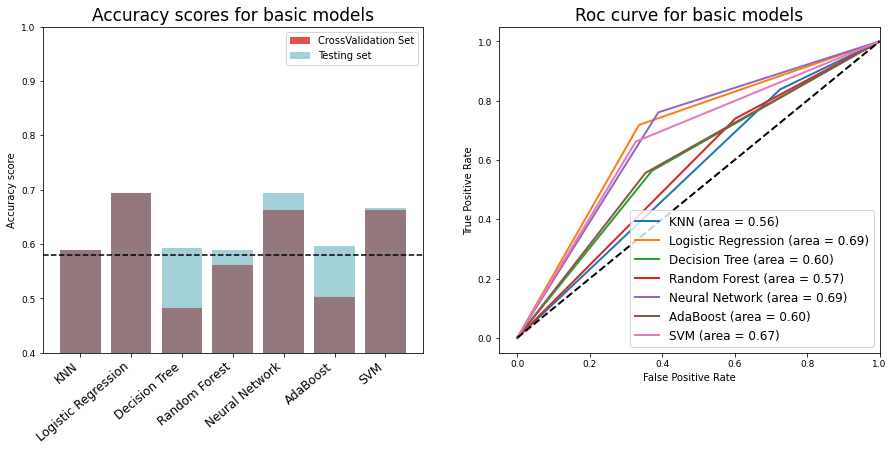

In [135]:
grafico_riassuntivo(knn_train, lg_train, dt_train, rf_train, rn_train, ad_train, svc_train, knn_test, lg_test, dt_test, rf_test, rn_test, ad_test, svc_test, knn_pred, lg_pred, dt_pred, rf_pred, rn_pred, ad_pred, svc_pred)

In [152]:
#Provo ad applicare tutte e 3 in metodi uno dietro l'altro.
selector = SelectKBest(score_func=f_classif, k=best_k)
selector.fit_transform(X_train, y_train)
selector.transform(X_test)

selected_columns_mask = selector.get_support()

# Ottieni i nomi delle colonne selezionate
selected_column_names = X_train.columns[selected_columns_mask]
print(selected_column_names)
X_new = X_train[selected_column_names]
X_test_new = X_test[selected_column_names]

regressor = LogisticRegression(max_iter = 1000)
feature_selector = RFECV(regressor)

print(X_new.columns)
fit = feature_selector.fit(X_new,y_train)

optimal_feature_count = feature_selector.n_features_
print(f"Optimal numer of features: {optimal_feature_count}")

X_new = X_new.loc[:, feature_selector.get_support()]
print(X_new.columns)

X_test_new = X_test_new[X_new.columns]



/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [670 673 674] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/danielepica/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Index(['age_at_diagnosis', 'cohort', 'neoplasm_histologic_grade',
       'lymph_nodes_examined_positive', 'nottingham_prognostic_index',
       'overall_survival_months', 'tumor_size', 'tumor_stage', 'bard1',
       'ccnb1', 'ccnd2', 'e2f2', 'src', 'jak1', 'jak2', 'stat3', 'stat5a',
       'stat5b', 'dtx2', 'notch3', 'psen1', 'akt1', 'aurka', 'bcl2', 'casp8',
       'diras3', 'gsk3b', 'igf1', 'mmp11', 'mmp15', 'pdgfb', 'rps6kb2',
       'slc19a1', 'smad4', 'tgfbr2', 'arid1a', 'kmt2c', 'abcb1', 'map4',
       'tubb4b', 'fancd2', 'flt3', 'lama2', 'ncoa3', 'cdkn2c', 'hsd17b11',
       'spry2', 'tp53_mut', 'gata3_mut',
       'type_of_breast_surgery_BREAST CONSERVING',
       'type_of_breast_surgery_MASTECTOMY', 'pam50_+_claudin-low_subtype_Her2',
       'pam50_+_claudin-low_subtype_LumA', 'integrative_cluster_3',
       'integrative_cluster_5',
       '3-gene_classifier_subtype_ER+/HER2- Low Prolif'],
      dtype='object')
Index(['age_at_diagnosis', 'cohort', 'neoplasm_histologic_grade',


In [155]:
print(X_new.shape[:])
print(X_test_new.shape[:])


(762, 30)
(255, 30)


In [159]:
#TEST DOPO AVER APPLICATO PCA
print("LOGISTIC REGRESSION")
#LOGISTIC REGRESSION
logistic_regression = LogisticRegression(random_state=42, max_iter=4000)
lg_pred, lg_test, lg_train = metrics(logistic_regression, X_new, X_test_new, y_train, y_test, 4)

#DECISION TREE
print("DECISION TREE")

dec_tree_clf = tree.DecisionTreeClassifier()
dt_pred, dt_test, dt_train = metrics(dec_tree_clf, X_new, X_test_new, y_train, y_test, 4)

#RETE NEURALE
print("NEURAL NETWORK")
params = {
    'solver': ['sgd', 'adam'],
    'activation': ['logistic', 'tanh', 'relu']
}
MLP_clf = GridSearchCV(MLPClassifier(alpha=1e-5, hidden_layer_sizes=(10, 7, 2), max_iter = 70000, random_state=42), params, n_jobs=-1, cv=5)
rn_pred, rn_test, rn_train = metrics(MLP_clf, X_new, X_test_new, y_train, y_test, 4)

#KNN
print("KNN")
params = {
    "n_neighbors" : [5,15,25,30,35,40, 100],
    "weights" : ["uniform" , "distance"]
    }
    #Under some circumstances, it is better to weight the neighbors such that nearer neighbors
    #contribute more to the fit. This can be accomplished through the weights
    #keyword. The default value, weights = 'uniform', assigns uniform
    #weights to each neighbor. weights = 'distance' assigns weights proportional
    #to the inverse of the distance from the query point.

clf_neighbors = GridSearchCV(neighbors.KNeighborsClassifier(), params, n_jobs = -1, cv = 4)
knn_pred, knn_test, knn_train = metrics(clf_neighbors, X_new, X_test_new, y_train, y_test, 4)

#Random forest
print("RANDOM FOREST")
cl_random_forest = RandomForestClassifier(random_state=42)
rf_pred, rf_test, rf_train = metrics(cl_random_forest, X_new, X_test_new, y_train, y_test, 4)

#Adaboost
print("ADABOOST")
ada_boost = AdaBoostClassifier(random_state=42)
ad_pred, ad_test, ad_train = metrics(ada_boost, X_new, X_test_new, y_train, y_test, 4)

#SVM
print("SVM")
clf_linearsvc = svm.LinearSVC(max_iter=4000)
svc_pred, svc_test, svc_train = metrics(clf_linearsvc, X_new, X_test_new, y_train, y_test, 4)


LOGISTIC REGRESSION
CV scores:  [0.703125   0.671875   0.71875    0.76190476]
CV Standard Deviation:  0.032442950566403186

CV Mean score:  0.7139136904761905
Train score:  0.8398950131233596
Test score:  0.7843137254901961

Accuratezza del modello:  0.7843137254901961
Precision: 0.8175182481751825
Recall: 0.7887323943661971
Matrice di confusione :
[[ 88  25]
 [ 30 112]]

DECISION TREE
CV scores:  [0.71875    0.75       0.6875     0.77777778]
CV Standard Deviation:  0.03378732718060515

CV Mean score:  0.7335069444444444
Train score:  1.0
Test score:  0.7411764705882353

Accuratezza del modello:  0.7411764705882353
Precision: 0.7753623188405797
Recall: 0.7535211267605634
Matrice di confusione :
[[ 82  31]
 [ 35 107]]

NEURAL NETWORK
CV scores:  [0.703125   0.8125     0.78125    0.71428571]
CV Standard Deviation:  0.04561920632595386

CV Mean score:  0.7527901785714286
Train score:  0.9212598425196851
Test score:  0.7607843137254902

Accuratezza del modello:  0.7607843137254902
Precisio

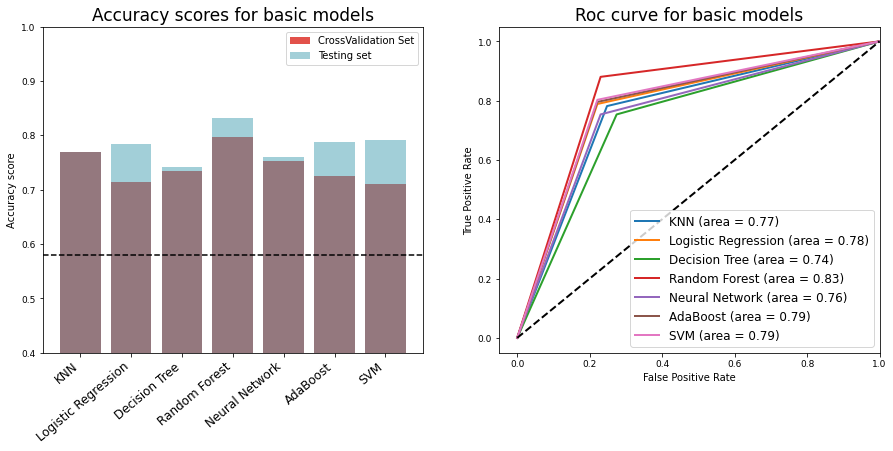

In [160]:
grafico_riassuntivo(knn_train, lg_train, dt_train, rf_train, rn_train, ad_train, svc_train, knn_test, lg_test, dt_test, rf_test, rn_test, ad_test, svc_test, knn_pred, lg_pred, dt_pred, rf_pred, rn_pred, ad_pred, svc_pred)